# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# import SCOPE-RL modules
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead, ContinuousEvalHead
from scope_rl.policy import TruncatedGaussianHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch

In [2]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# version
print(scope_rl.__version__)

0.1.2


In [4]:
# set random state
random_state = 12345

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [7]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic , the objective of the RL agent is to maximize reward

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.


For more about the environmental configuration and its customization, please refer to [examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).

In [8]:
# standardized environment for continuous action
env = gym.make("BasicEnv-continuous-v0")

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection.ipynb).

In [9]:
# behavior policy
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# model
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high,  
    ),
).create(device=device)

# setup replay buffer
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=10000,
    n_steps_per_epoch=100,
    update_start_step=100,
)

In [12]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [10]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

In [11]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [12]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=5, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=5, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [17]:
with open("logs/train_dataset_continuous_sac_multi.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac_multi.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [13]:
with open("logs/train_dataset_continuous_sac_multi.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac_multi.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

<!-- For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb). -->

In [14]:
# import modules
from scope_rl.policy import TrainCandidatePolicies
# import models from d3rlpy
from d3rlpy.algos import CQLConfig, IQLConfig

In [15]:
# evaluation policies
cql_b1 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
).create(device=device)

cql_b2 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
).create(device=device)

cql_b3 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
).create(device=device)

iql_b1 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
).create(device=device)

iql_b2 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
).create(device=device)

iql_b3 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
).create(device=device)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [16]:
# initialize OPL class
opl = TrainCandidatePolicies(
    fitting_args={
        "n_steps": 10000,
    }
)

In [ ]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

In [23]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [17]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [18]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [19]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [20]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [21]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput

In [22]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    bandwidth=1.0,
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [31]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [23]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [24]:
# import ope modules from SCOPE-RL
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.continuous import DirectMethod as DM
from scope_rl.ope.continuous import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.continuous import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.continuous import DoublyRobust as DR
from scope_rl.ope.continuous import SelfNormalizedTIS as SNTIS
from scope_rl.ope.continuous import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.continuous import SelfNormalizedDR as SNDR

In [25]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), SNTIS(), SNPDIS(), SNDR()],
    bandwidth=10.0,
)

In [49]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':            policy_value  relative_policy_value
 on_policy      3.238754               1.000000
 dm             5.619502               1.735082
 sntis          2.329536               0.719269
 snpdis         0.957332               0.295586
 sndr           1.047092               0.323301,
 'cql_b1_gauss_10':            policy_value  relative_policy_value
 on_policy      1.419149               1.000000
 dm             5.074568               3.575783
 sntis          2.330039               1.641857
 snpdis         0.956302               0.673856
 sndr          -0.407971              -0.287476,
 'cql_b2_gauss_05':            policy_value  relative_policy_value
 on_policy      3.499362               1.000000
 dm             5.224175               1.492894
 sntis          2.329910               0.665810
 snpdis         0.957599               0.273650
 sndr           1.158038               0.330928,
 'cql_b2_gauss_10':            policy_value  relative_policy_value
 on_polic

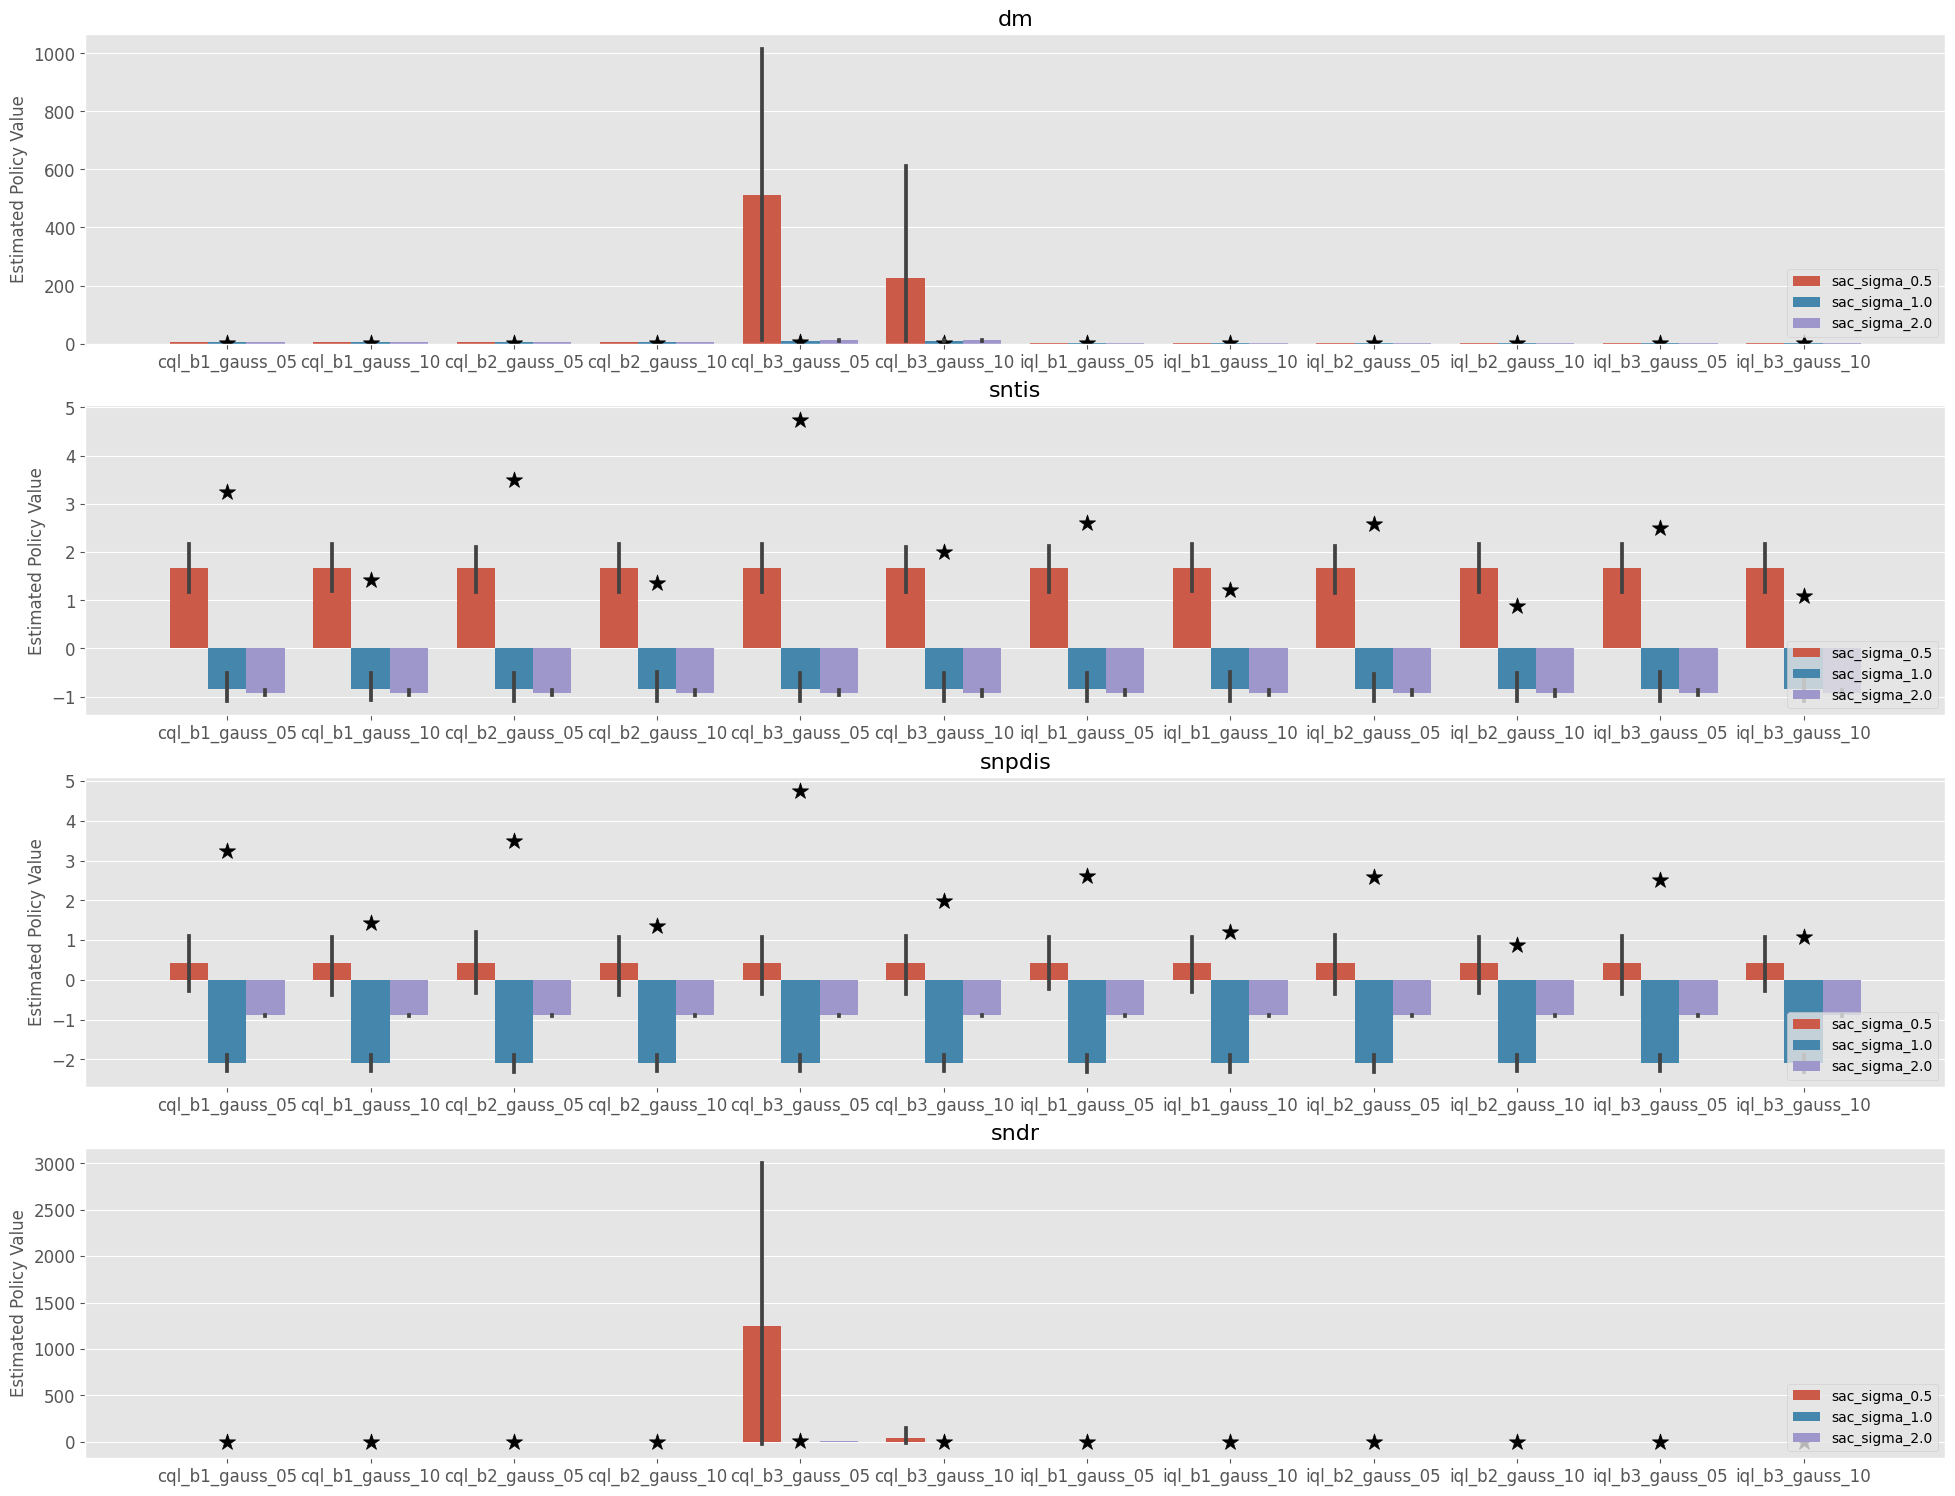

In [50]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

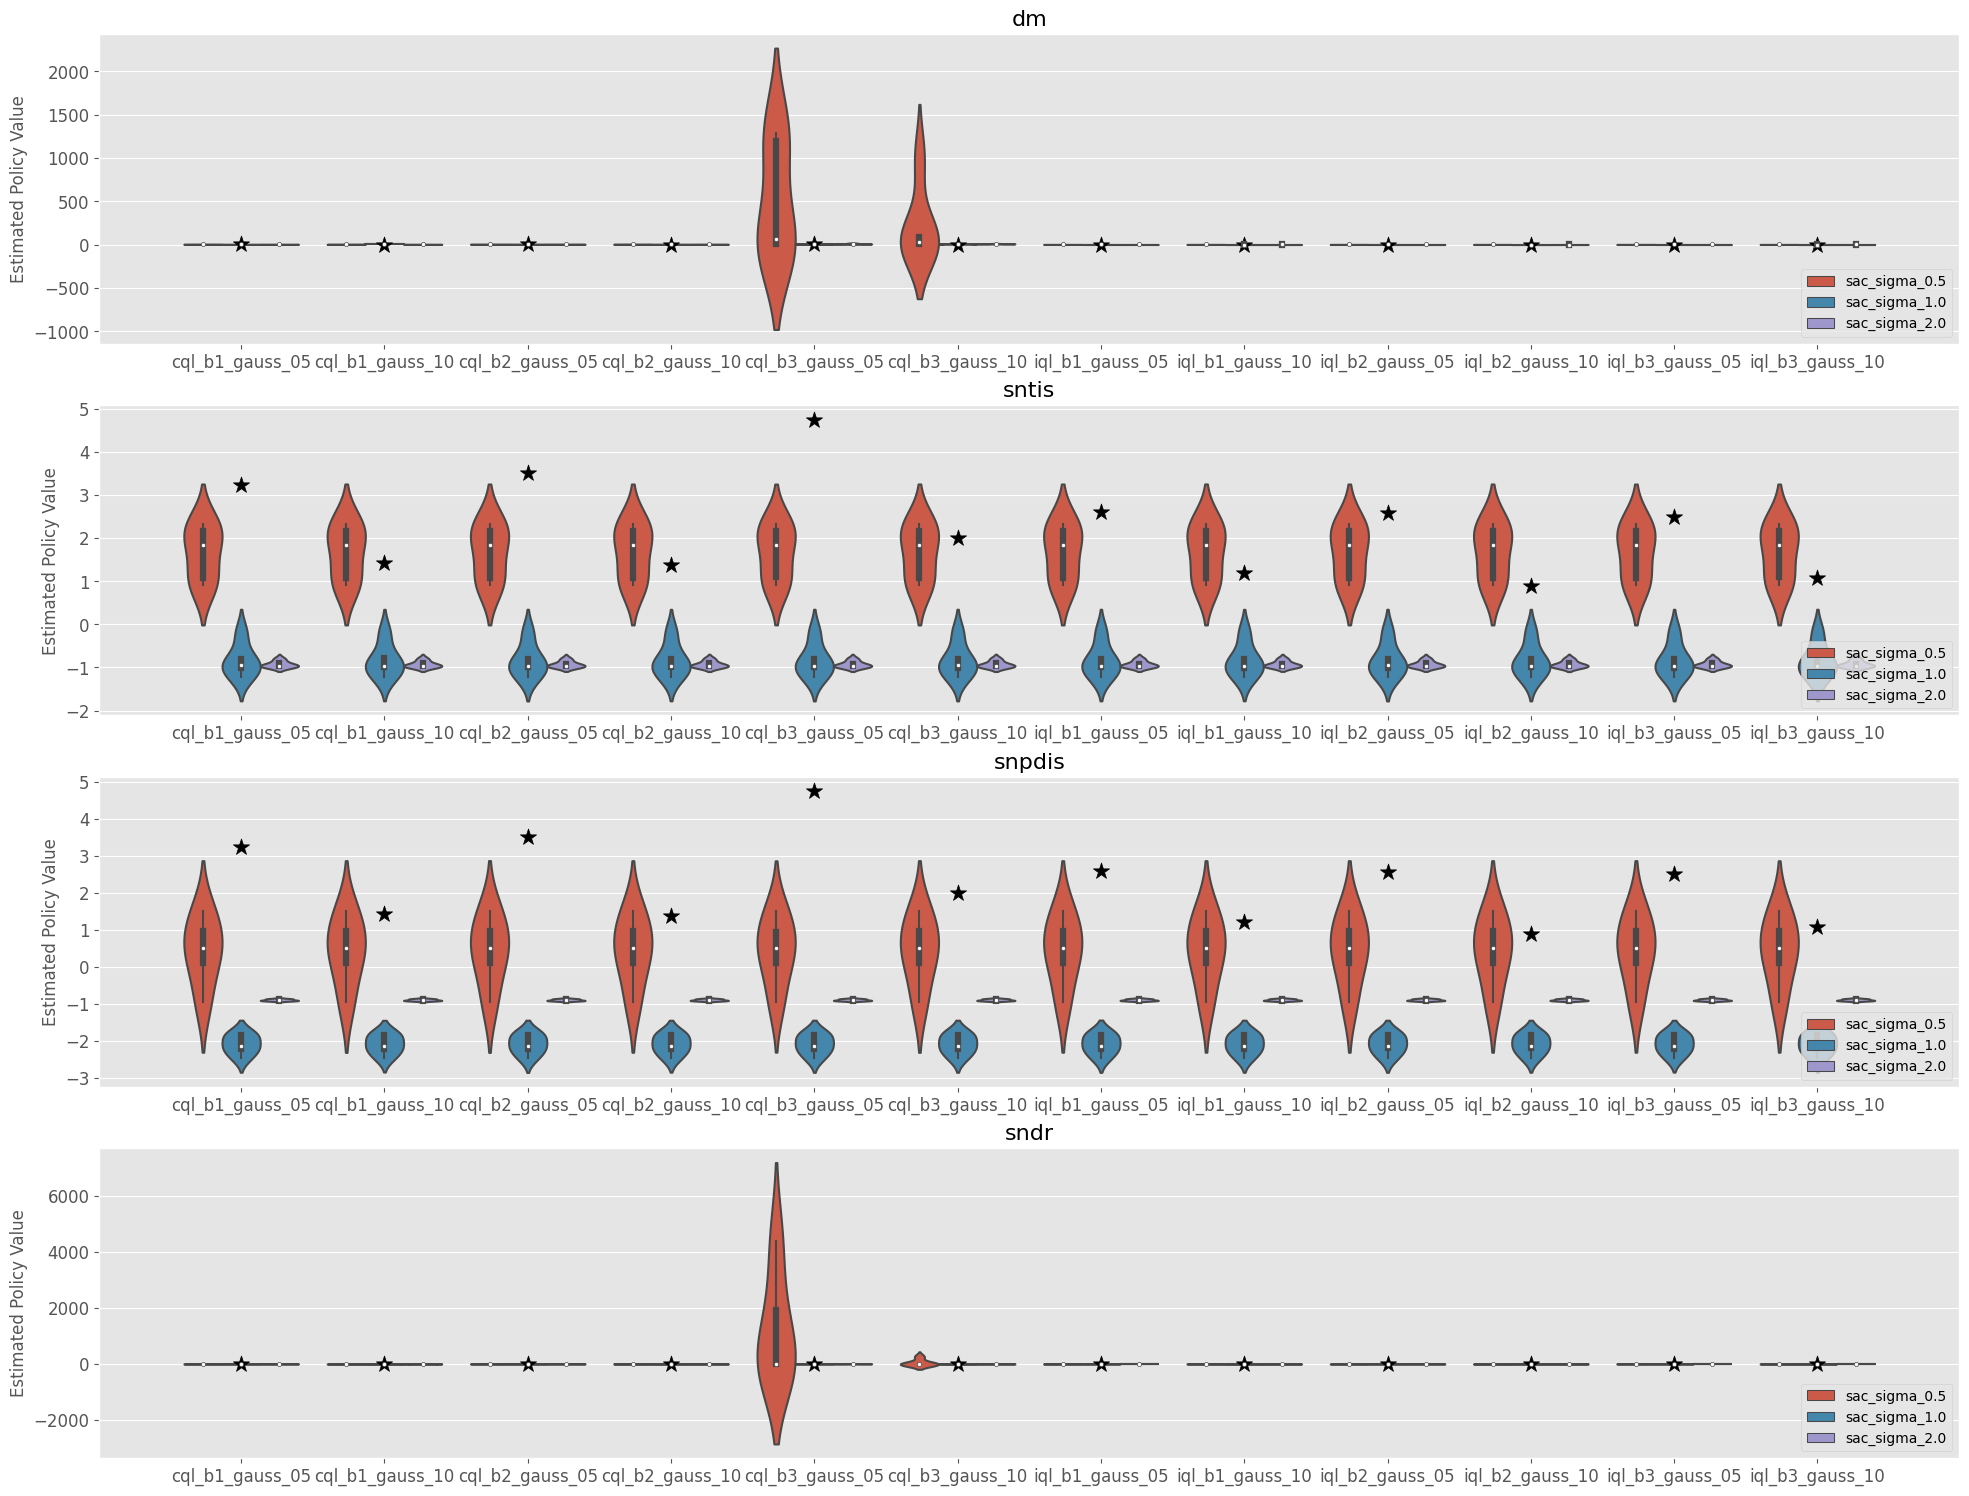

In [51]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

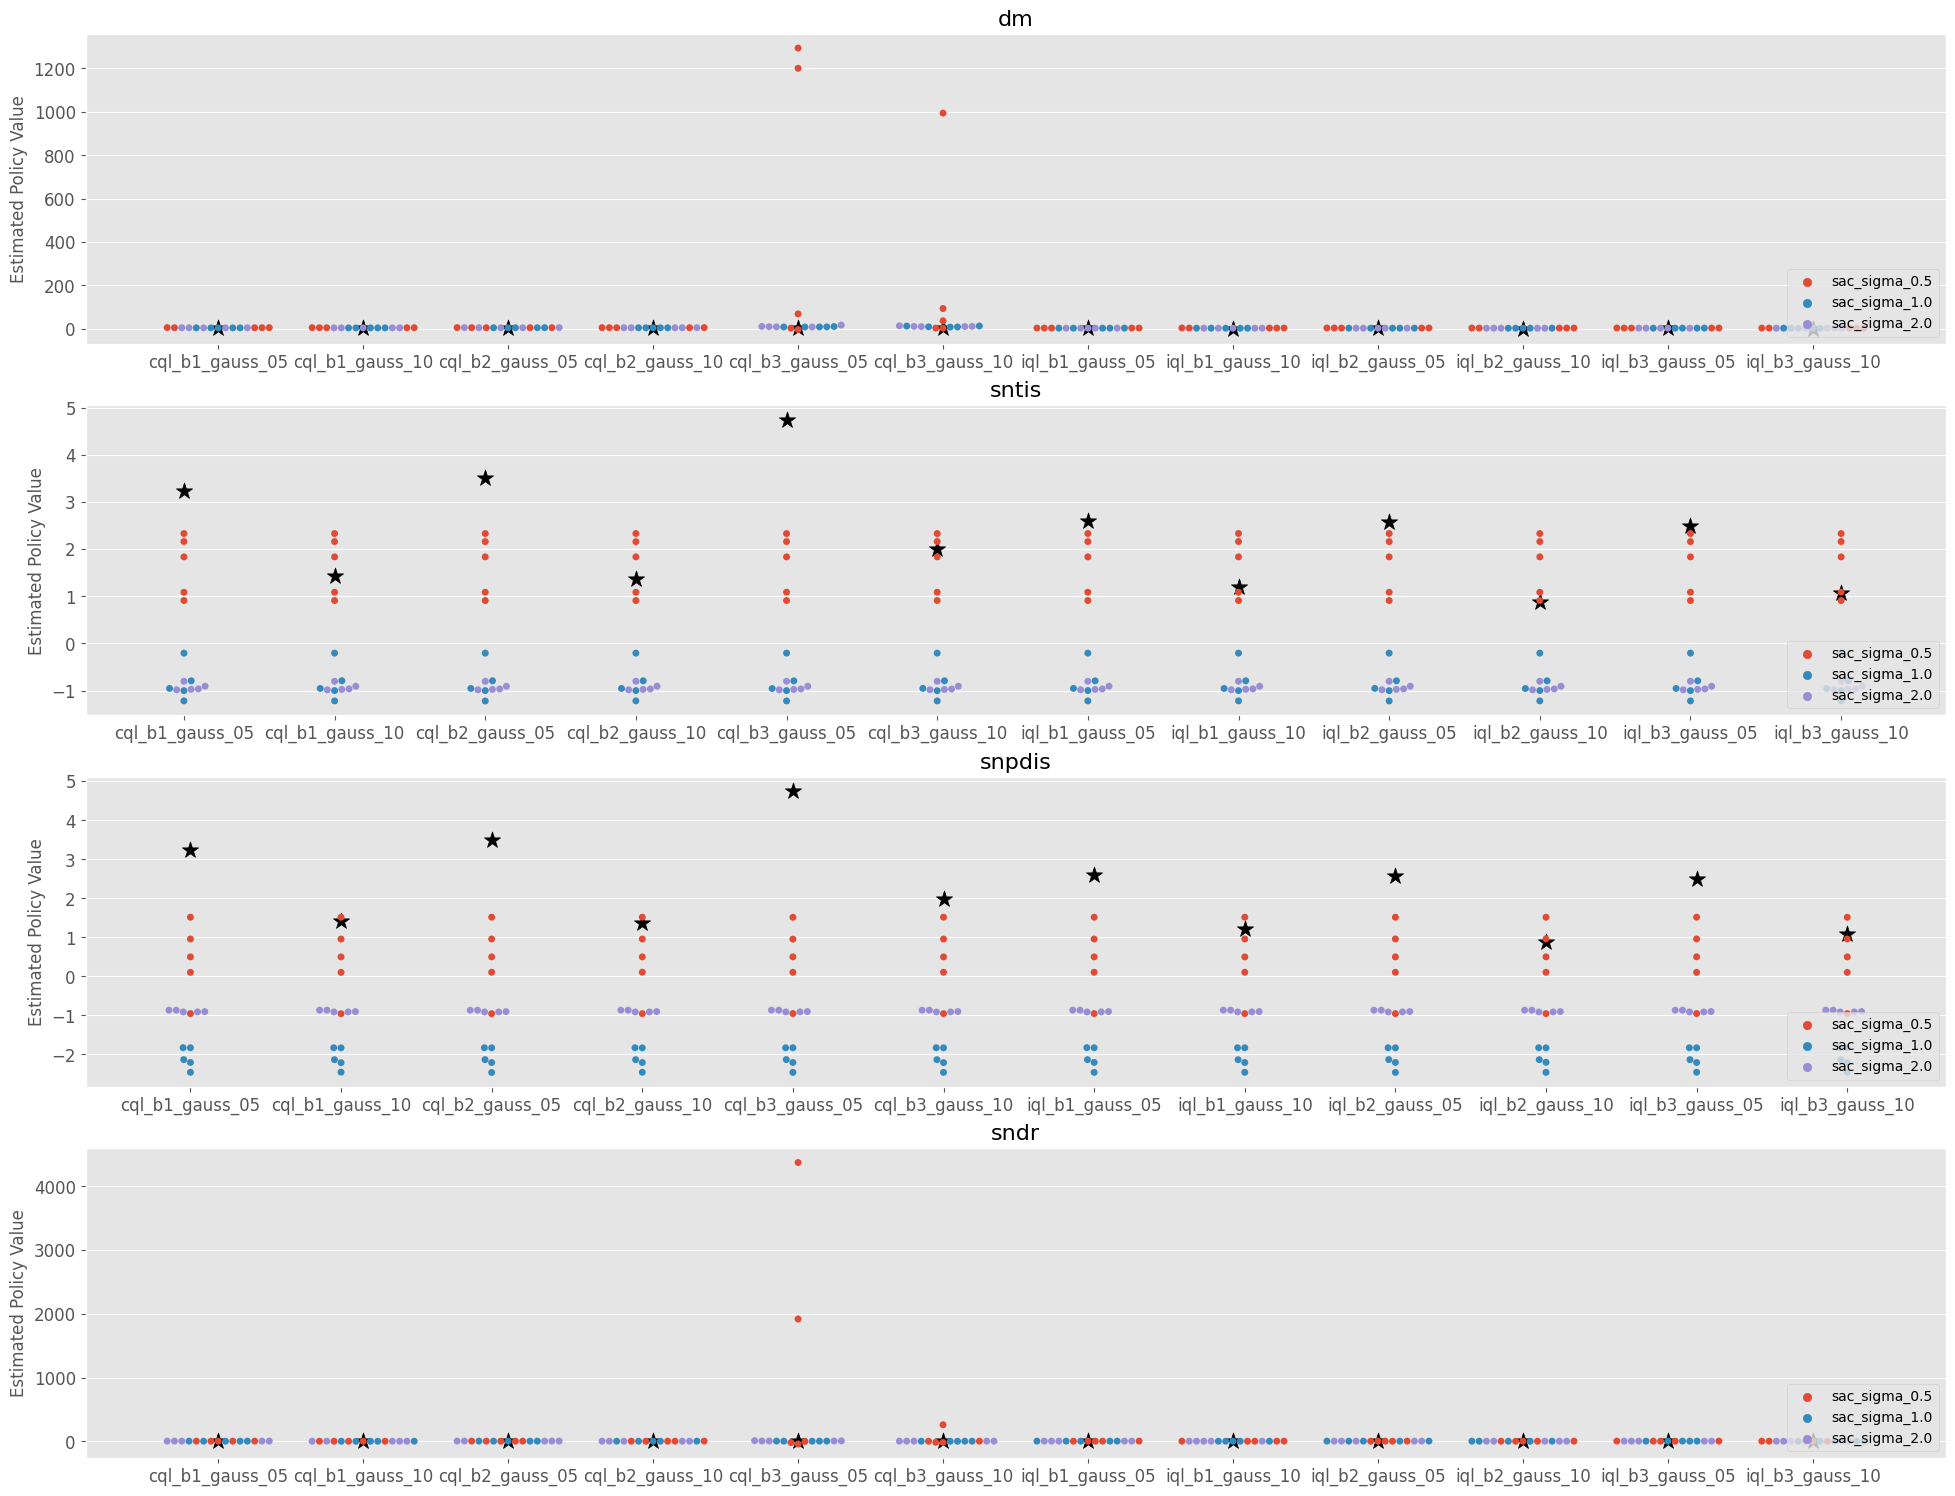

In [52]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [26]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.continuous import CumulativeDistributionDM as CD_DM
from scope_rl.ope.continuous import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.continuous import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.continuous import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.continuous import CumulativeDistributionSNTDR as CD_SNDR

In [27]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

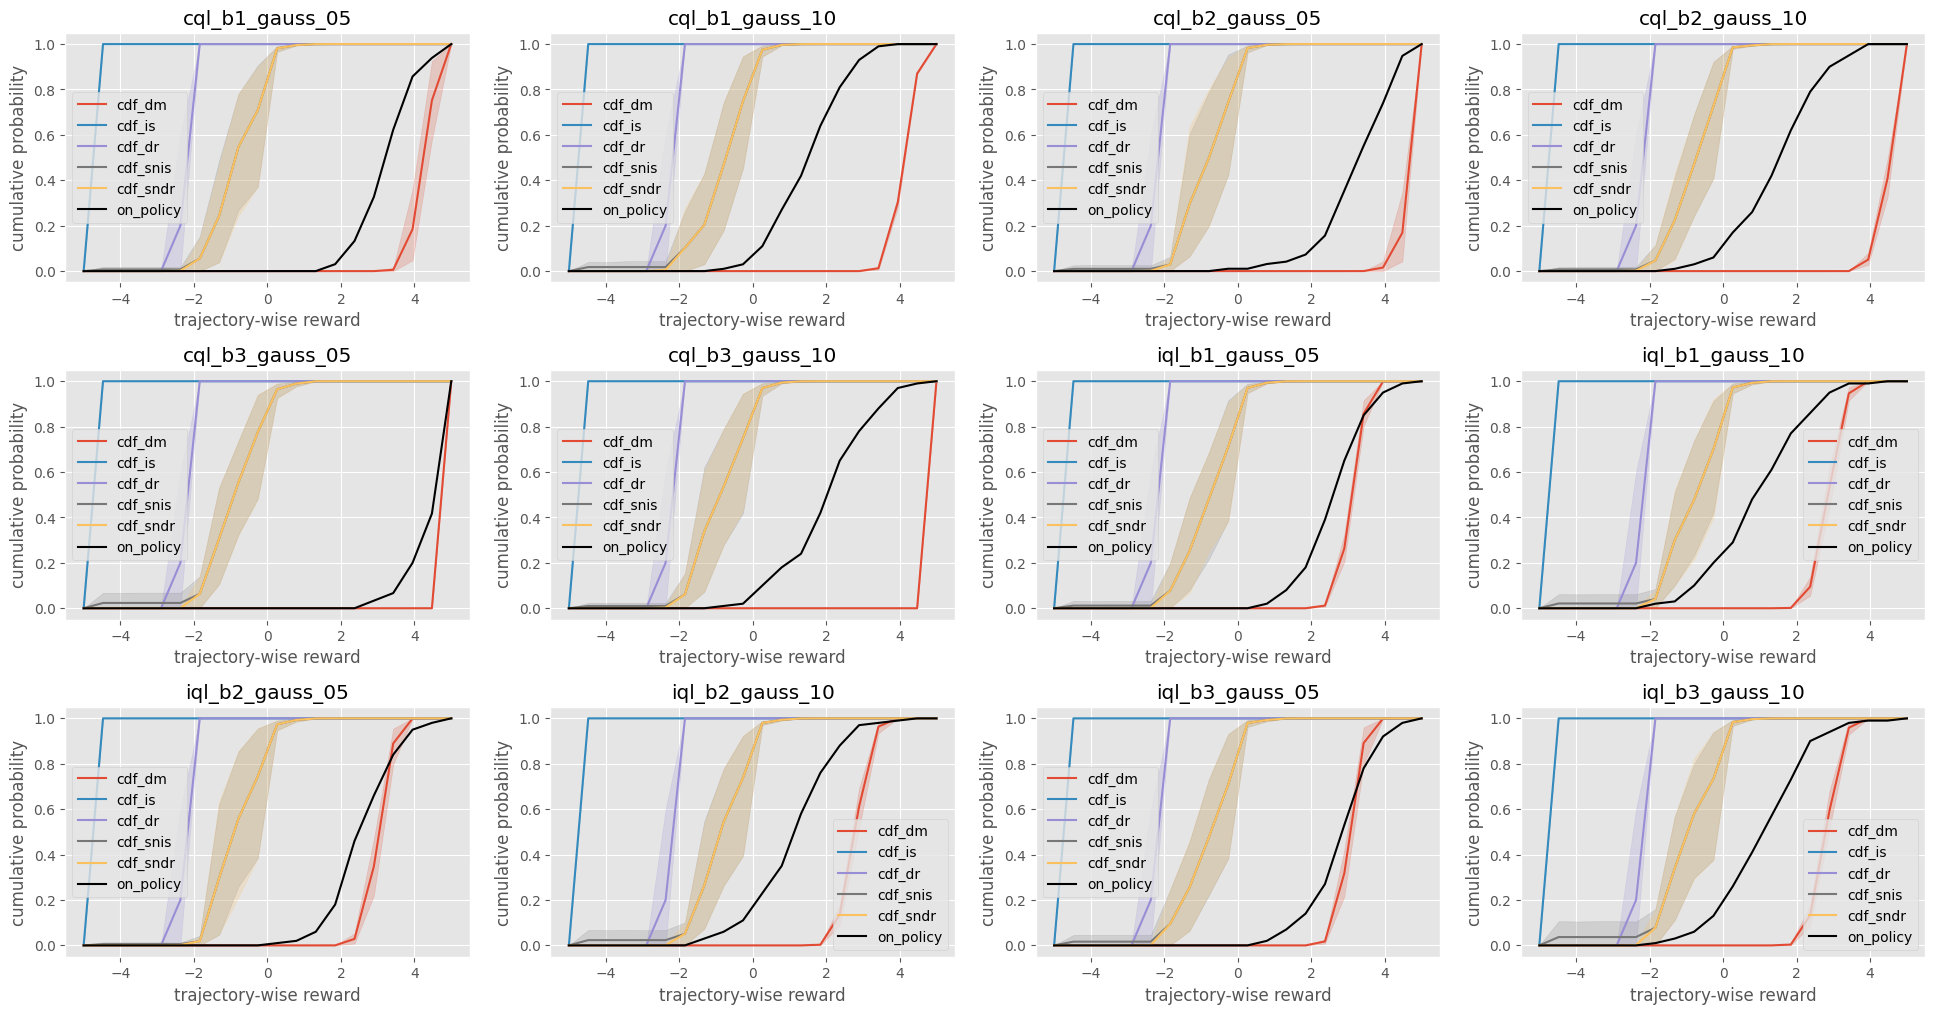

In [55]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=-5.0, 
    scale_max=5.0, 
    n_partition=20, 
    n_cols=4,
)

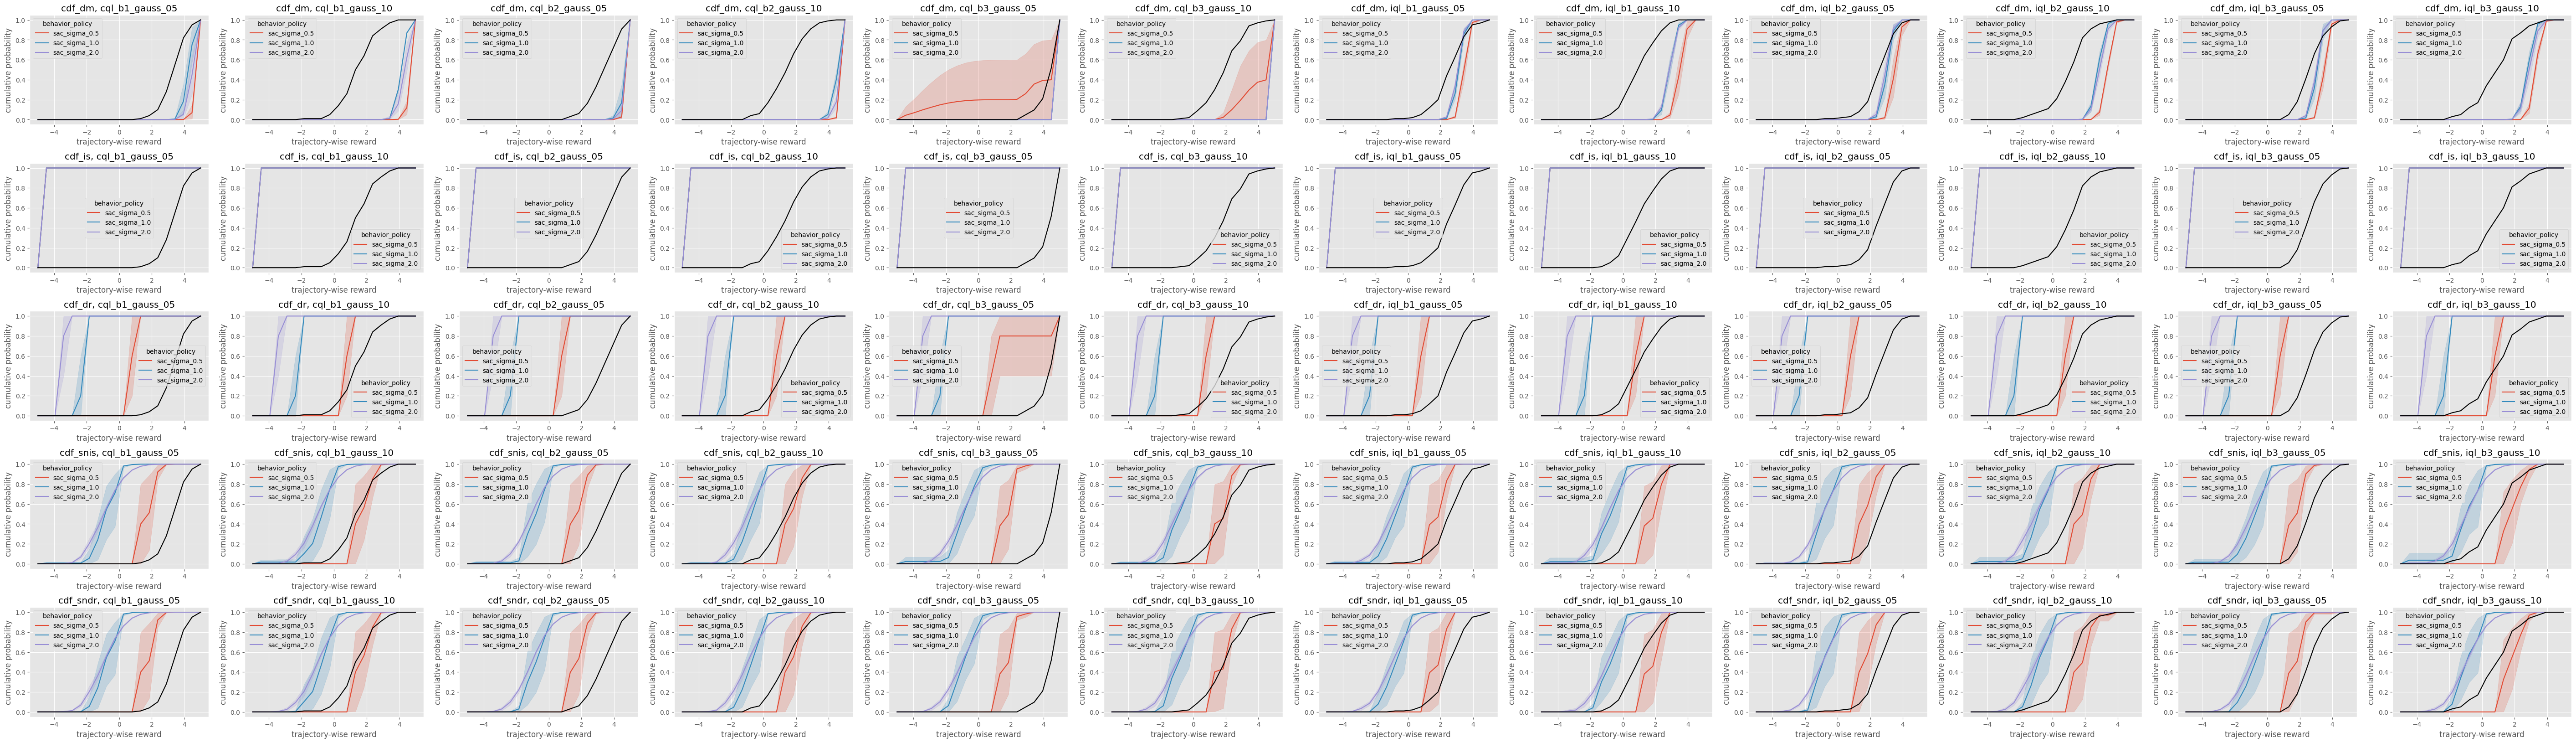

In [56]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=-5.0, 
    scale_max=5.0, 
    n_partition=20, 
)

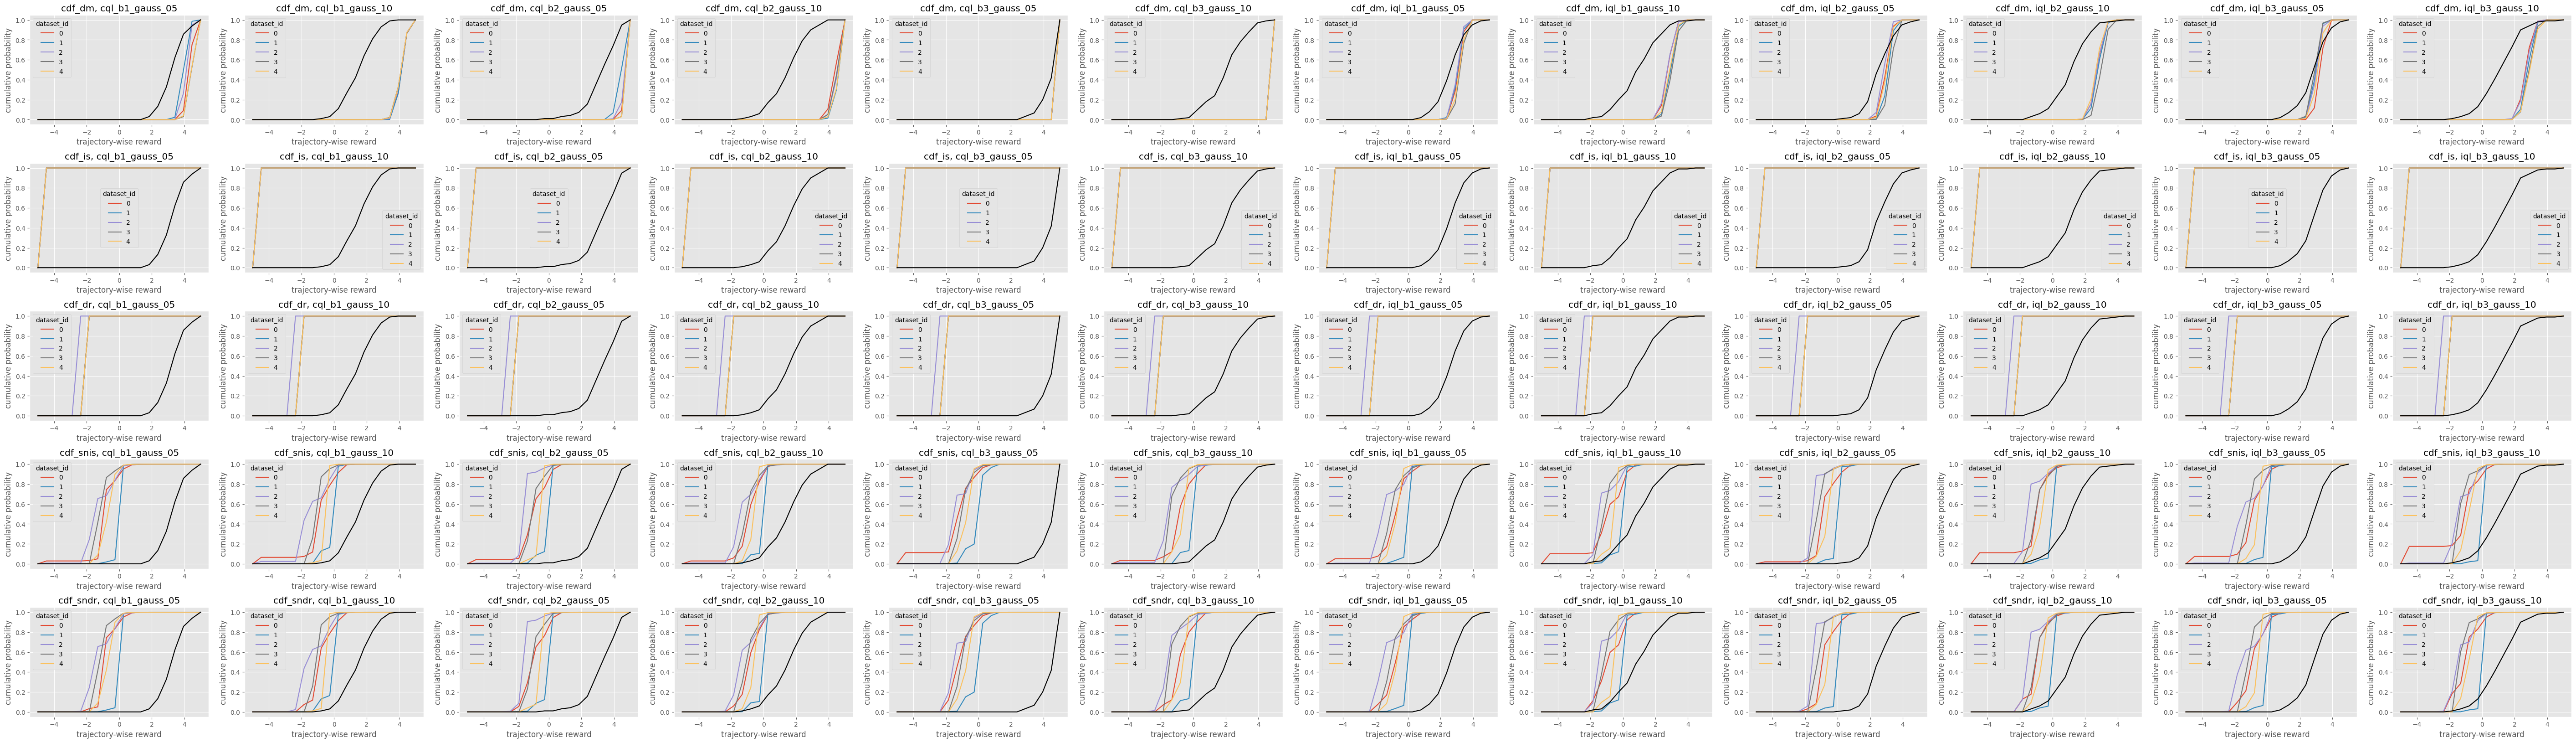

In [57]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=-5.0, 
    scale_max=5.0, 
    n_partition=20, 
)

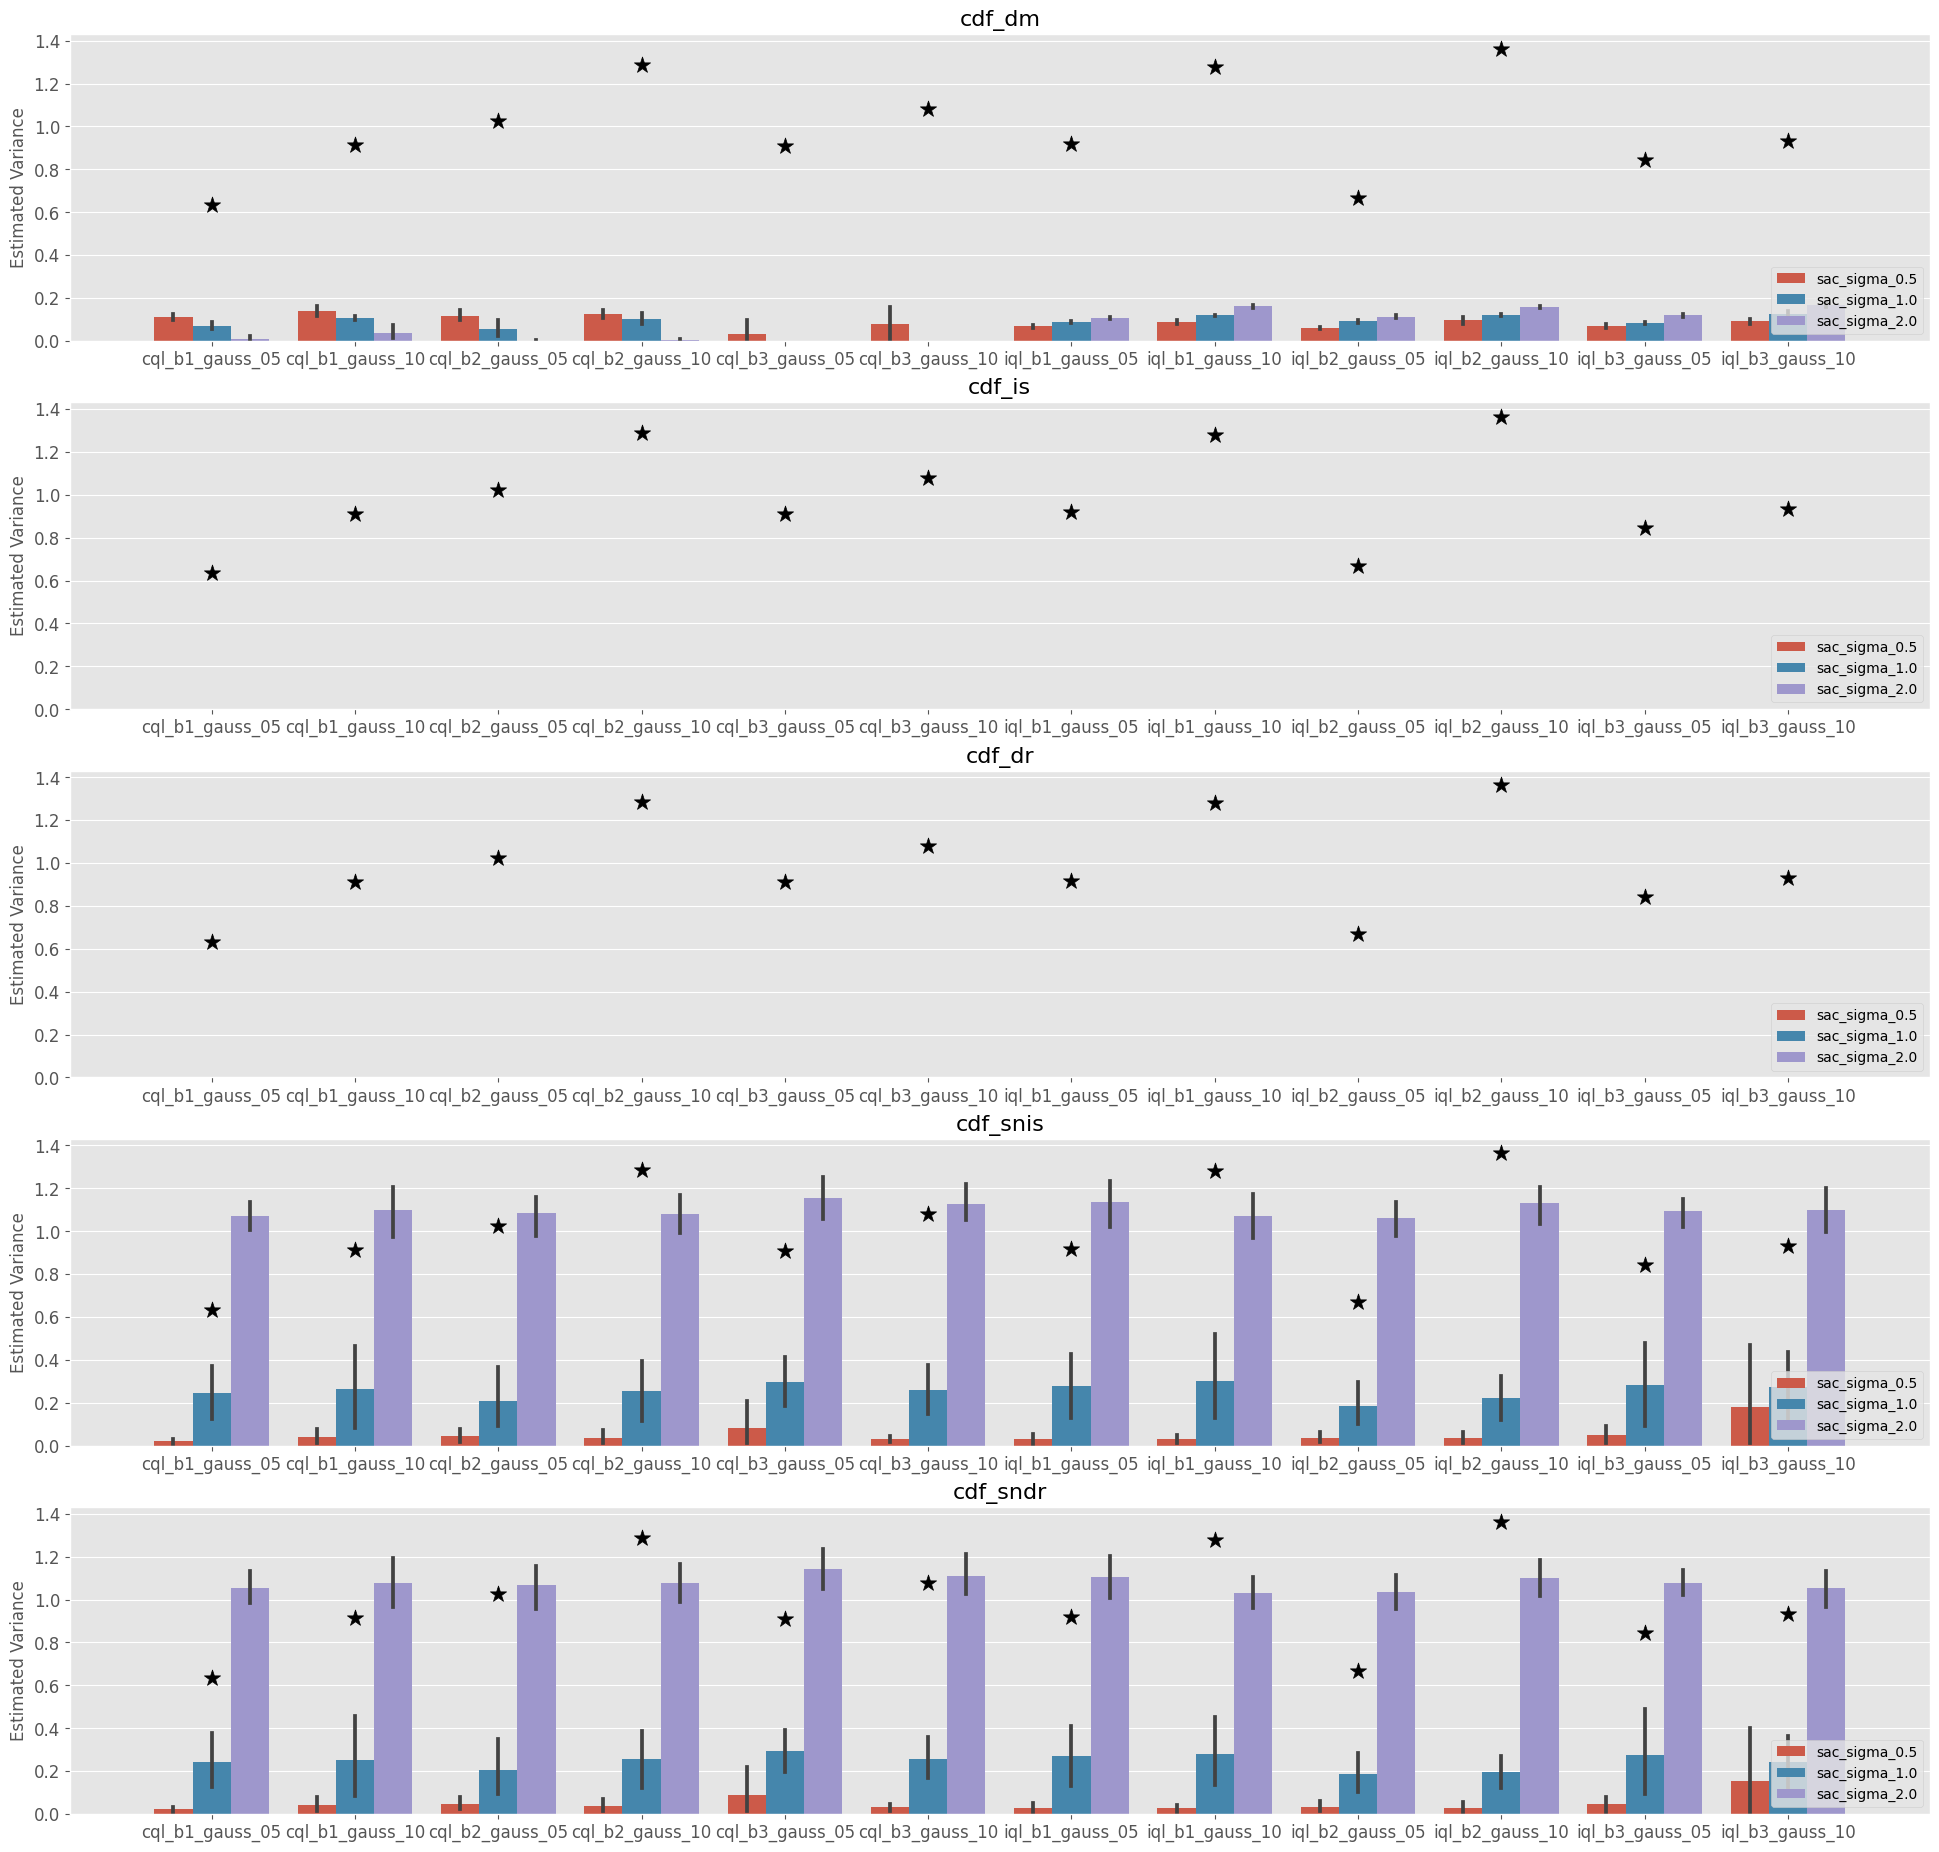

In [58]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

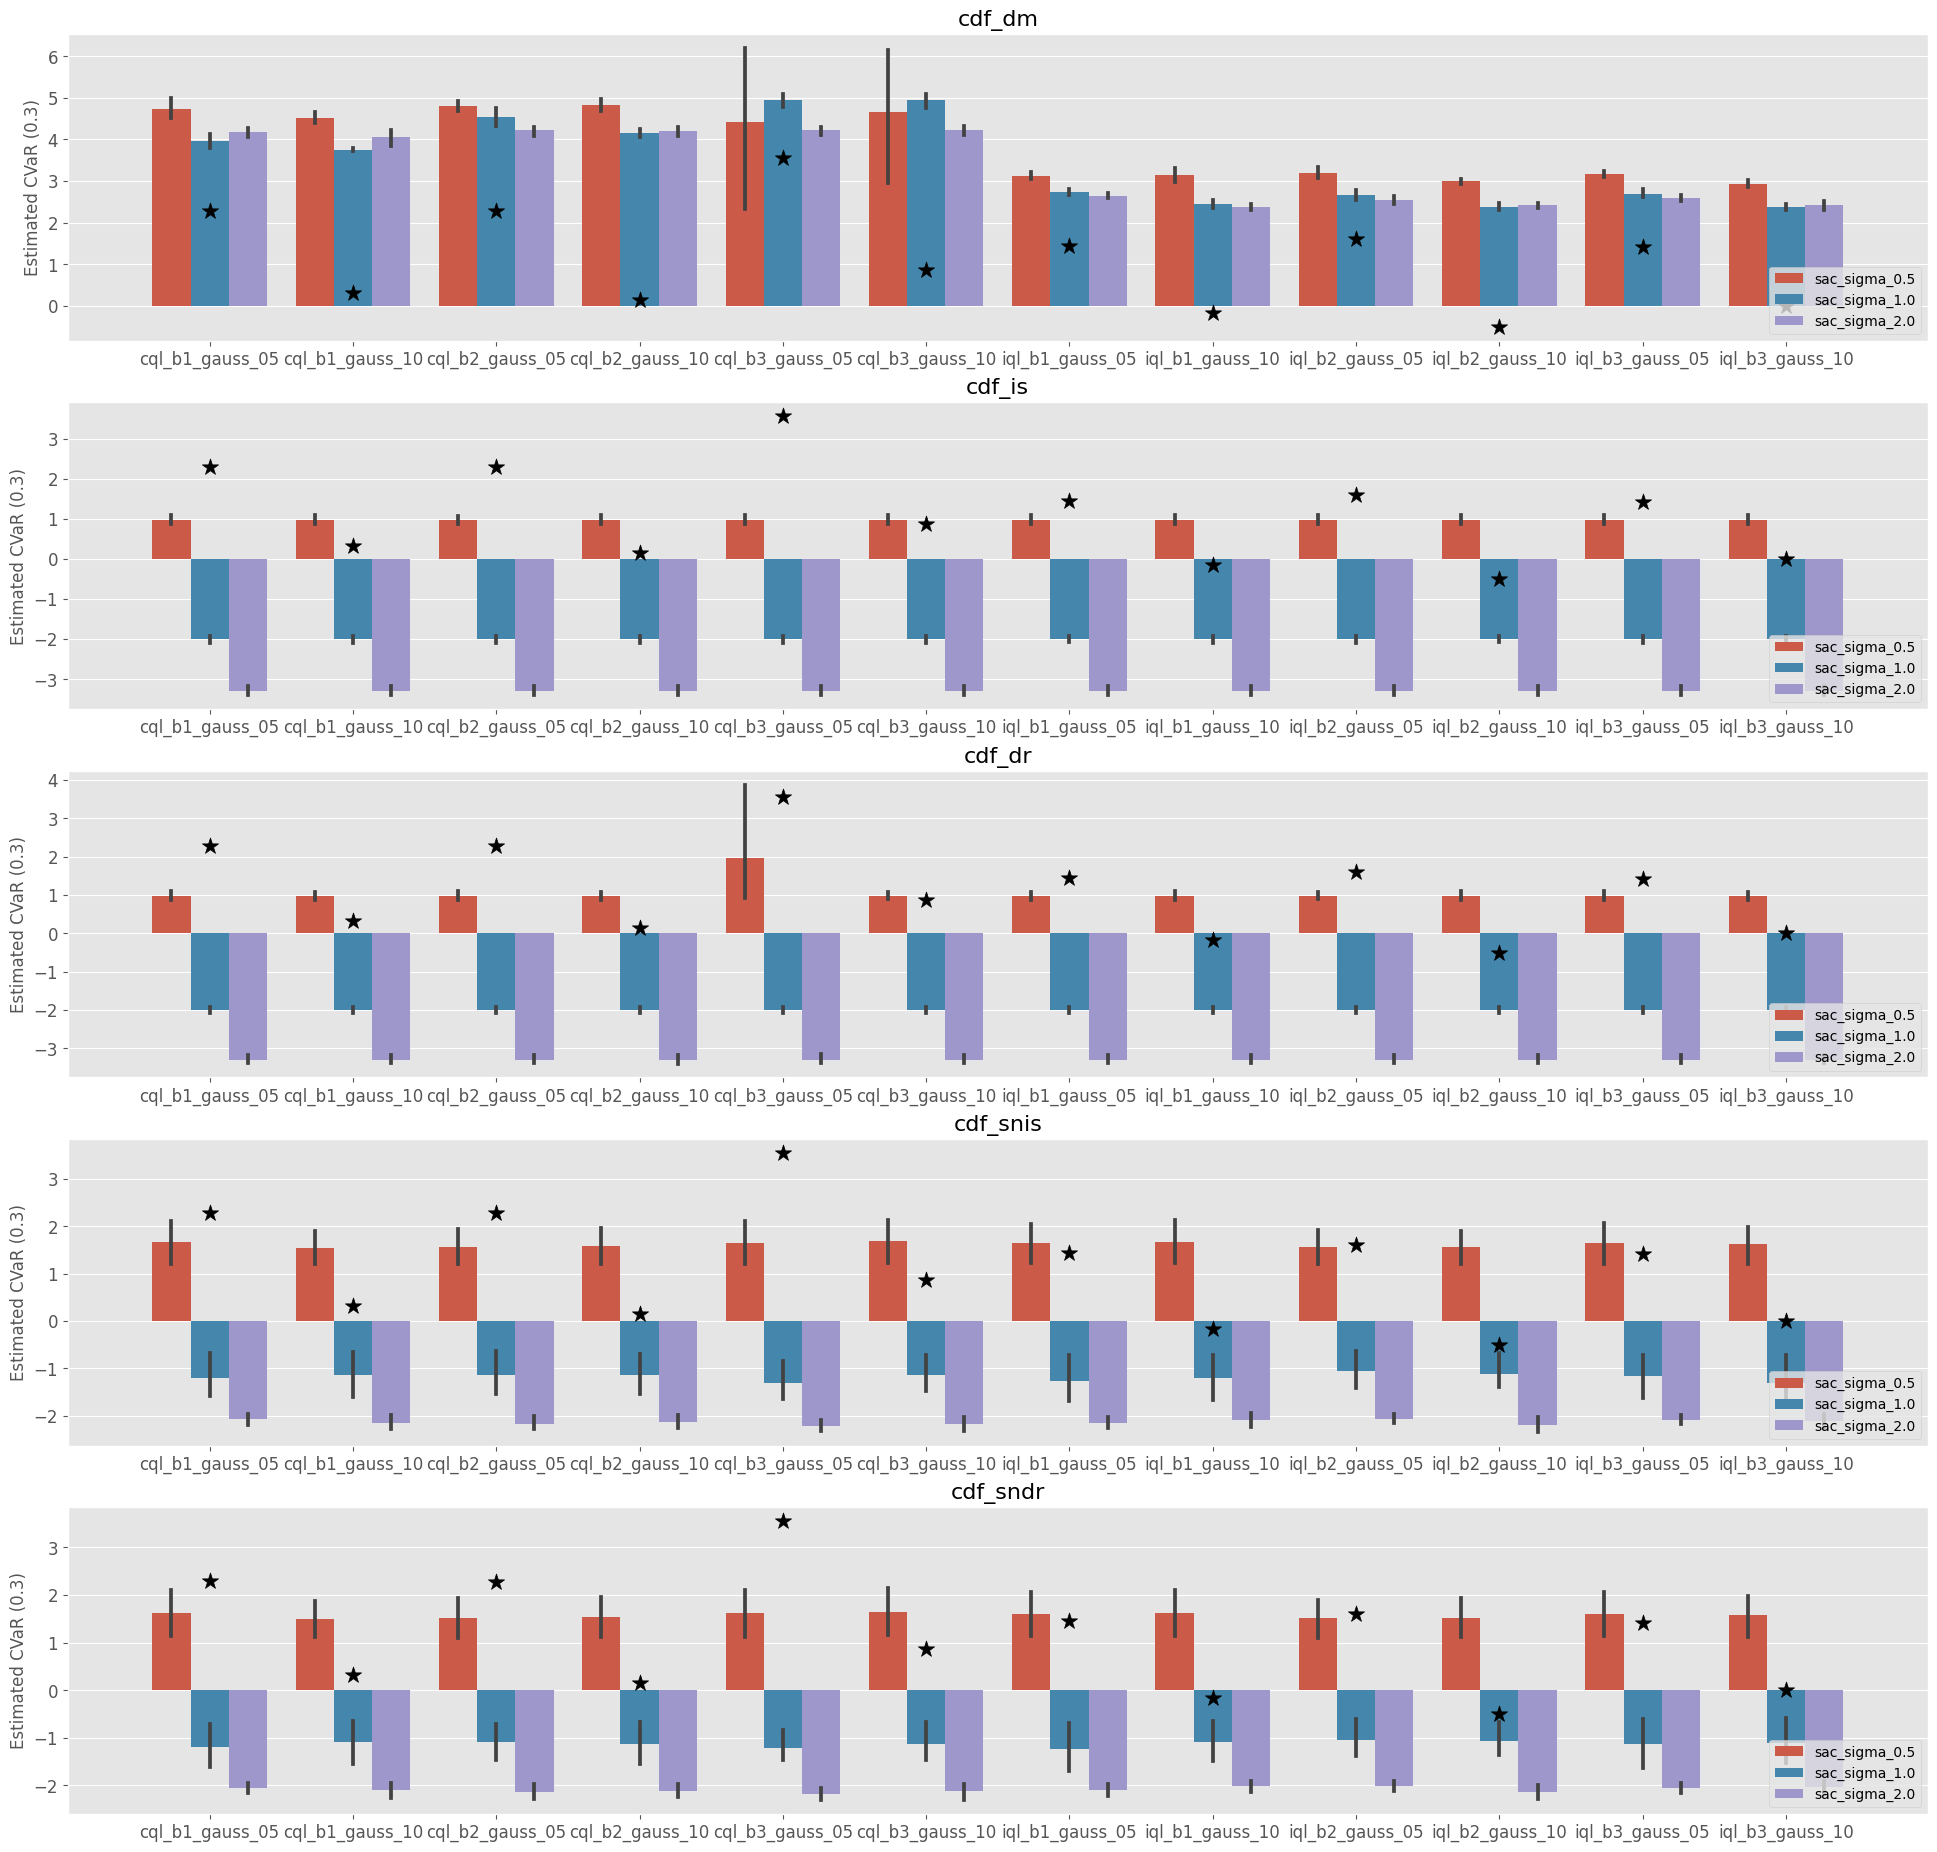

In [59]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

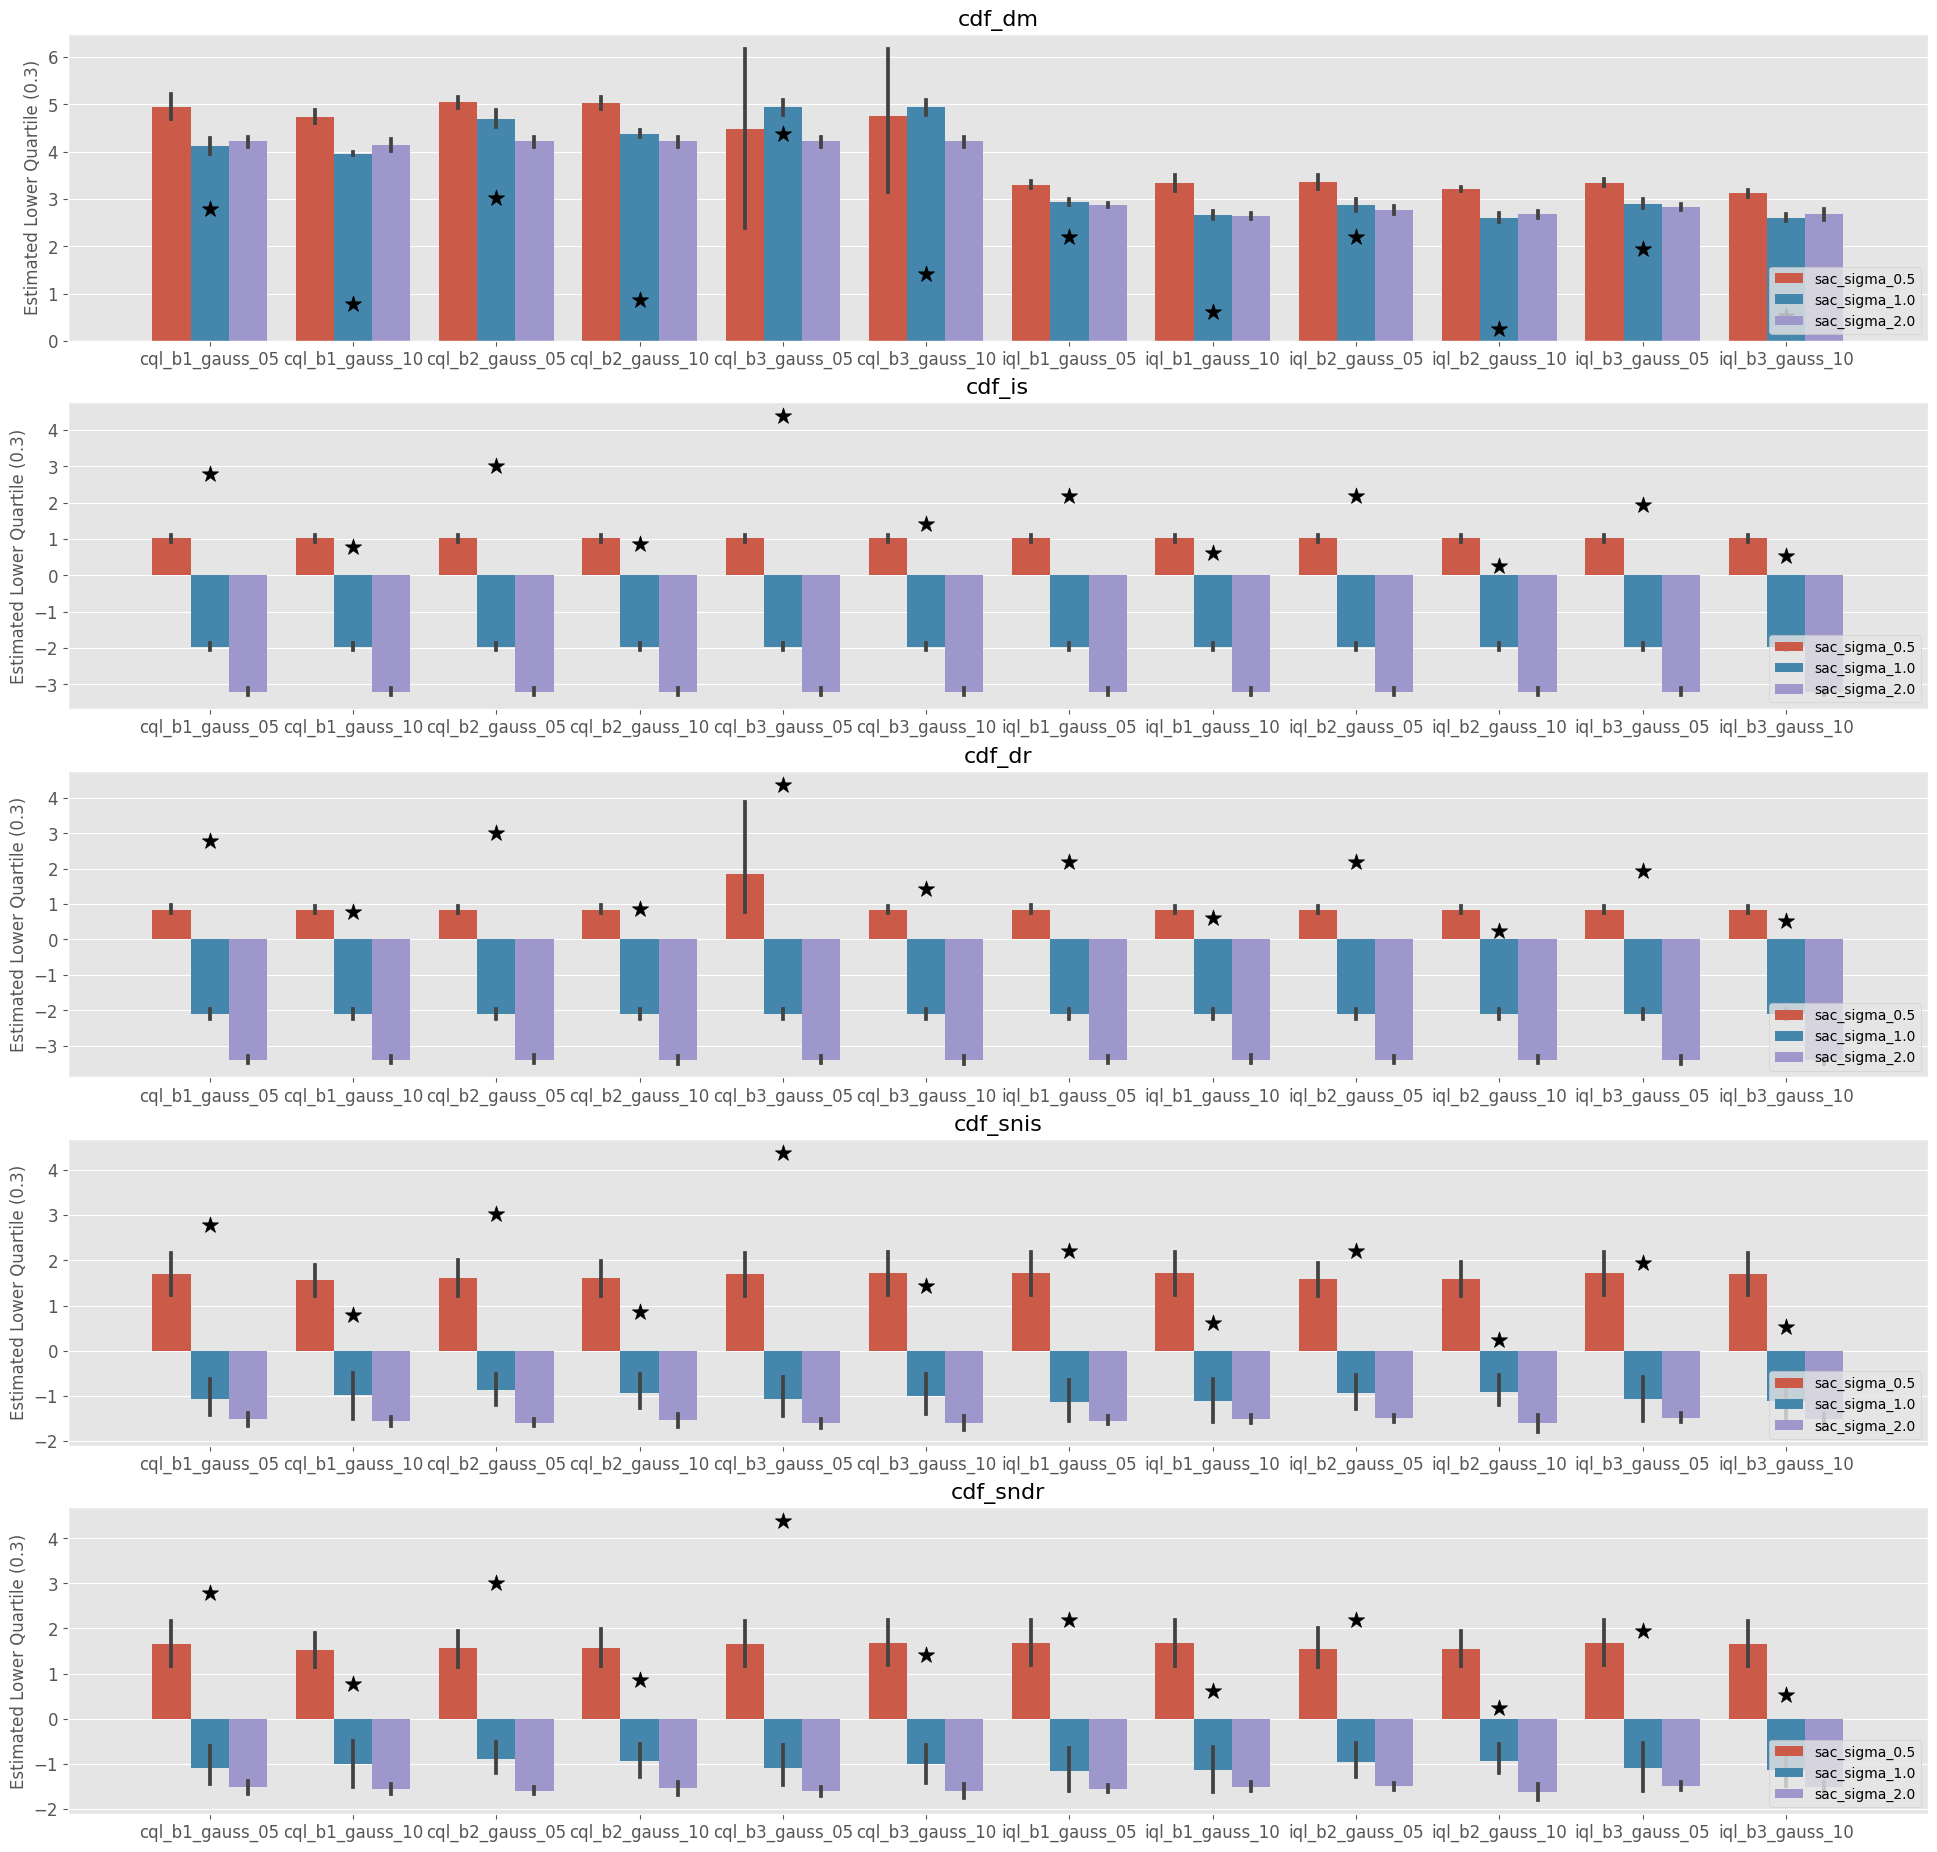

In [60]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [28]:
from scope_rl.ope import OffPolicySelection

In [29]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [30]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

ranking  policy_value  relative_policy_value  variance  \
0   cql_b3_gauss_05      4.746981               1.232701  0.910117   
1   cql_b2_gauss_05      3.499362               0.908718  1.024089   
2   cql_b1_gauss_05      3.238754               0.841043  0.633643   
3   iql_b1_gauss_05      2.601002               0.675431  0.918170   
4   iql_b2_gauss_05      2.574397               0.668522  0.668074   
5   iql_b3_gauss_05      2.498324               0.648767  0.843451   
6   cql_b3_gauss_10      1.993449               0.517661  1.079265   
7   cql_b1_gauss_10      1.419149               0.368526  0.911918   
8   cql_b2_gauss_10      1.365547               0.354607  1.286080   
9   iql_b1_gauss_10      1.201524               0.312013  1.279004   
10  iql_b3_gauss_10      1.078748               0.280131  0.931714   
11  iql_b2_gauss_10      0.882339               0.229127  1.362803   

   ranking_by_lower_quartile  lower_quartile  \
0            cql_b1_gauss_05        3.156892   
1            cql_b1_gauss_10        1.854003   
2            cql_b2_gauss_05        1.850892   
3            cql_b2_gauss_10        1.306692   
4            cql_b3_gauss_05        0.988773   
5            cql_b3_gauss_10        0.833498   
6            iql_b1_gauss_05        0.387334   
7            iql_b1_gauss_10        0.105821   
8            iql_b2_gauss_05       -0.498417   
9            iql_b2_gauss_10       -0.524757   
10           iql_b3_gauss_05       -0.655118   
11           iql_b3_gauss_10       -1.002487   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                       cql_b3_gauss_05                   2.553211  
1                       cql_b1_gauss_05                   1.566556  
2                       cql_b2_gauss_05                   1.312060  
3                       iql_b2_gauss_05                   0.850780  
4                       iql_b1_gauss_05                   0.654465  
5                       iql_b3_gauss_05                   0.562219  
6                       cql_b3_gauss_10                  -0.111088  
7                       cql_b1_gauss_10                  -0.402209  
8                       iql_b3_gauss_10                  -0.807126  
9                       cql_b2_gauss_10                  -0.939337  
10                      iql_b1_gauss_10                  -1.082800  
11                      iql_b2_gauss_10                  -1.455928

In [31]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [32]:
ranking_df[behavior_policies[0].name][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0    cql_b3_gauss_10              994.197744                       258.174286   
 1    cql_b1_gauss_05                5.619502                         1.459278   
 2    cql_b2_gauss_05                5.224175                         1.356619   
 3    cql_b2_gauss_10                5.127014                         1.331388   
 4    cql_b1_gauss_10                5.074568                         1.317769   
 5    iql_b1_gauss_10                3.762357                         0.977013   
 6    iql_b2_gauss_05                3.510500                         0.911610   
 7    iql_b3_gauss_05                3.455235                         0.897259   
 8    iql_b2_gauss_10                3.395732                         0.881807   
 9    iql_b1_gauss_05                3.389292                         0.880135   
 10   iql_b3_gauss_10                3.292752                         0.855065   
 11   cql_

In [66]:
metric_df[behavior_policies[0].name][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm        82044.028682          0.083916  0.795415  2.753533   
1     sntis            1.251074         -0.811189  0.001363  3.545457   
2    snpdis            2.939703         -0.384615  0.217020  3.864642   
3      sndr         5514.676668         -0.048951  0.879919  2.753533   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.000000                 0.0  
2           0.000000                 0.0  
3           0.166667                 0.0

In [33]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    return_safety_violation_rate=True,
    safety_threshold=2.0,
    return_by_dataframe=True,
)

In [34]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  3.080323  3.080323  3.080323  3.080323       NaN   
1         dm     1  3.511319  4.628479  1.963164  3.295821  1.884662   
2         dm     2  2.694936  4.645852  1.806075  3.095526  1.472217   
3         dm     3  2.045814  4.645852  1.438043  2.833098  1.439894   
4         dm     4  2.368207  4.645852  1.388848  2.740120  1.348789   
5         dm     5  2.047044  4.645852  1.319397  2.624607  1.302311   
6         dm     6  2.426341  4.645852  1.286798  2.596283  1.206566   
7         dm     7  2.485344  4.645852  1.244466  2.582416  1.129474   
8         dm     8  1.864386  4.645852  1.139722  2.502635  1.109378   
9         dm     9  1.498119  4.645852  0.945070  2.402183  1.130806   
10        dm    10  1.216191  4.645852  0.905128  2.294366  1.146792   
11        dm    11  1.643638  4.837438  0.875784  2.240139  1.189543   
0      sntis     0  1.821381  1.821381  1.821381  1.821381       NaN   
1      sntis     1  2.441649  2.819364  1.443666  2.131515  0.972765   
2      sntis     2  1.846927  3.027923  1.153812  2.036652  0.968266   
3      sntis     3  2.500208  3.396648  1.073935  2.152541  1.044987   
4      sntis     4  2.088192  3.442428  1.014088  2.139671  0.979560   
5      sntis     5  2.233770  3.760507  0.918849  2.155355  1.064348   
6      sntis     6  2.446301  3.873258  0.918849  2.196918  1.045857   
7      sntis     7  1.314731  3.873258  0.901850  2.086645  1.046960   
8      sntis     8  2.686502  4.034692  0.901850  2.153296  1.061778   
9      sntis     9  2.001243  4.229132  0.896460  2.138090  1.087752   
10     sntis    10  3.084127  4.647829  0.875784  2.224094  1.169147   
11     sntis    11  2.416632  4.837438  0.875784  2.240139  1.189543   
0     snpdis     0  2.028263  2.028263  2.028263  2.028263       NaN   
1     snpdis     1  2.290592  2.722082  1.596773  2.159428  0.795713   
2     snpdis     2  2.472615  3.445430  1.209327  2.263823  1.191383   
3     snpdis     3  2.480403  3.699858  1.096413  2.317968  1.165350   
4     snpdis     4  2.240775  3.812396  0.994265  2.302530  1.122069   
5     snpdis     5  2.297306  4.162409  0.961715  2.301659  1.176488   

    safety_violation_rate  sharpe_ratio  
0                0.533333           NaN  
1                0.433333      1.347512  
2                0.400000      1.778741  
3                0.466667      1.838824  
4                0.466667      1.966145  
5                0.488889      2.033054  
6                0.438095      2.192012  
7                0.391667      2.366304  
8                0.400000      2.441692  
9                0.426667      2.387310  
10               0.466667      2.339049  
11               0.488889      2.423315  
0                0.733333           NaN  
1                0.533333      1.617064  
2                0.555556      1.566359  
3                0.483333      1.690354  
4                0.480000      1.780148  
5                0.488889      1.830549  
6                0.457143      1.987258  
7                0.516667      1.957702  
8                0.488889      2.025010  
9                0.506667      2.142501  
10               0.478788      2.279485  
11               0.488889      2.423315  
0                0.466667           NaN  
1                0.433333      2.461769  
2                0.422222      1.463069  
3                0.400000      1.651981  
4                0.413333      1.739930  
5                0.422222      1.869880

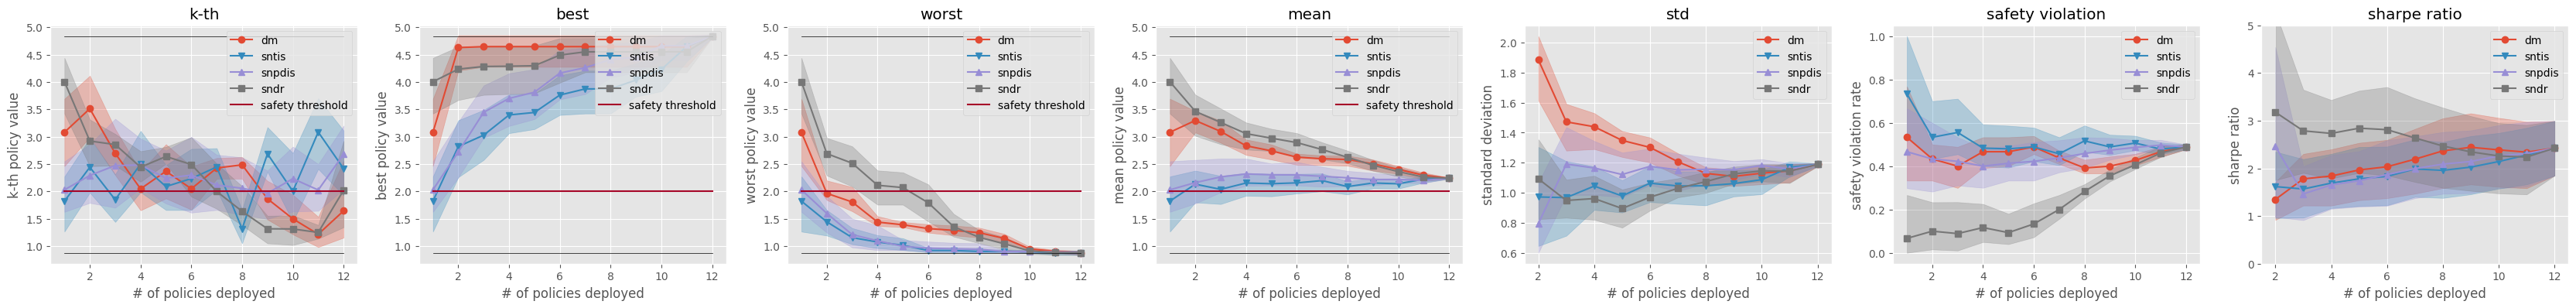

In [35]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    visualize_ci=True,
    safety_threshold=2.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

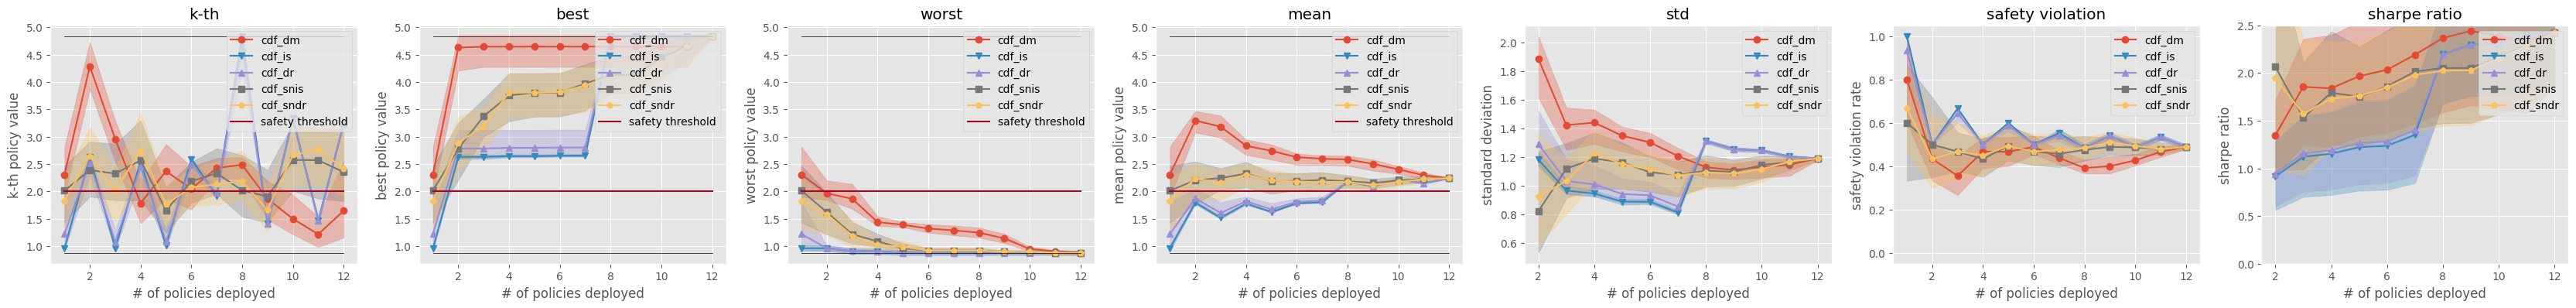

In [36]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_threshold=2.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

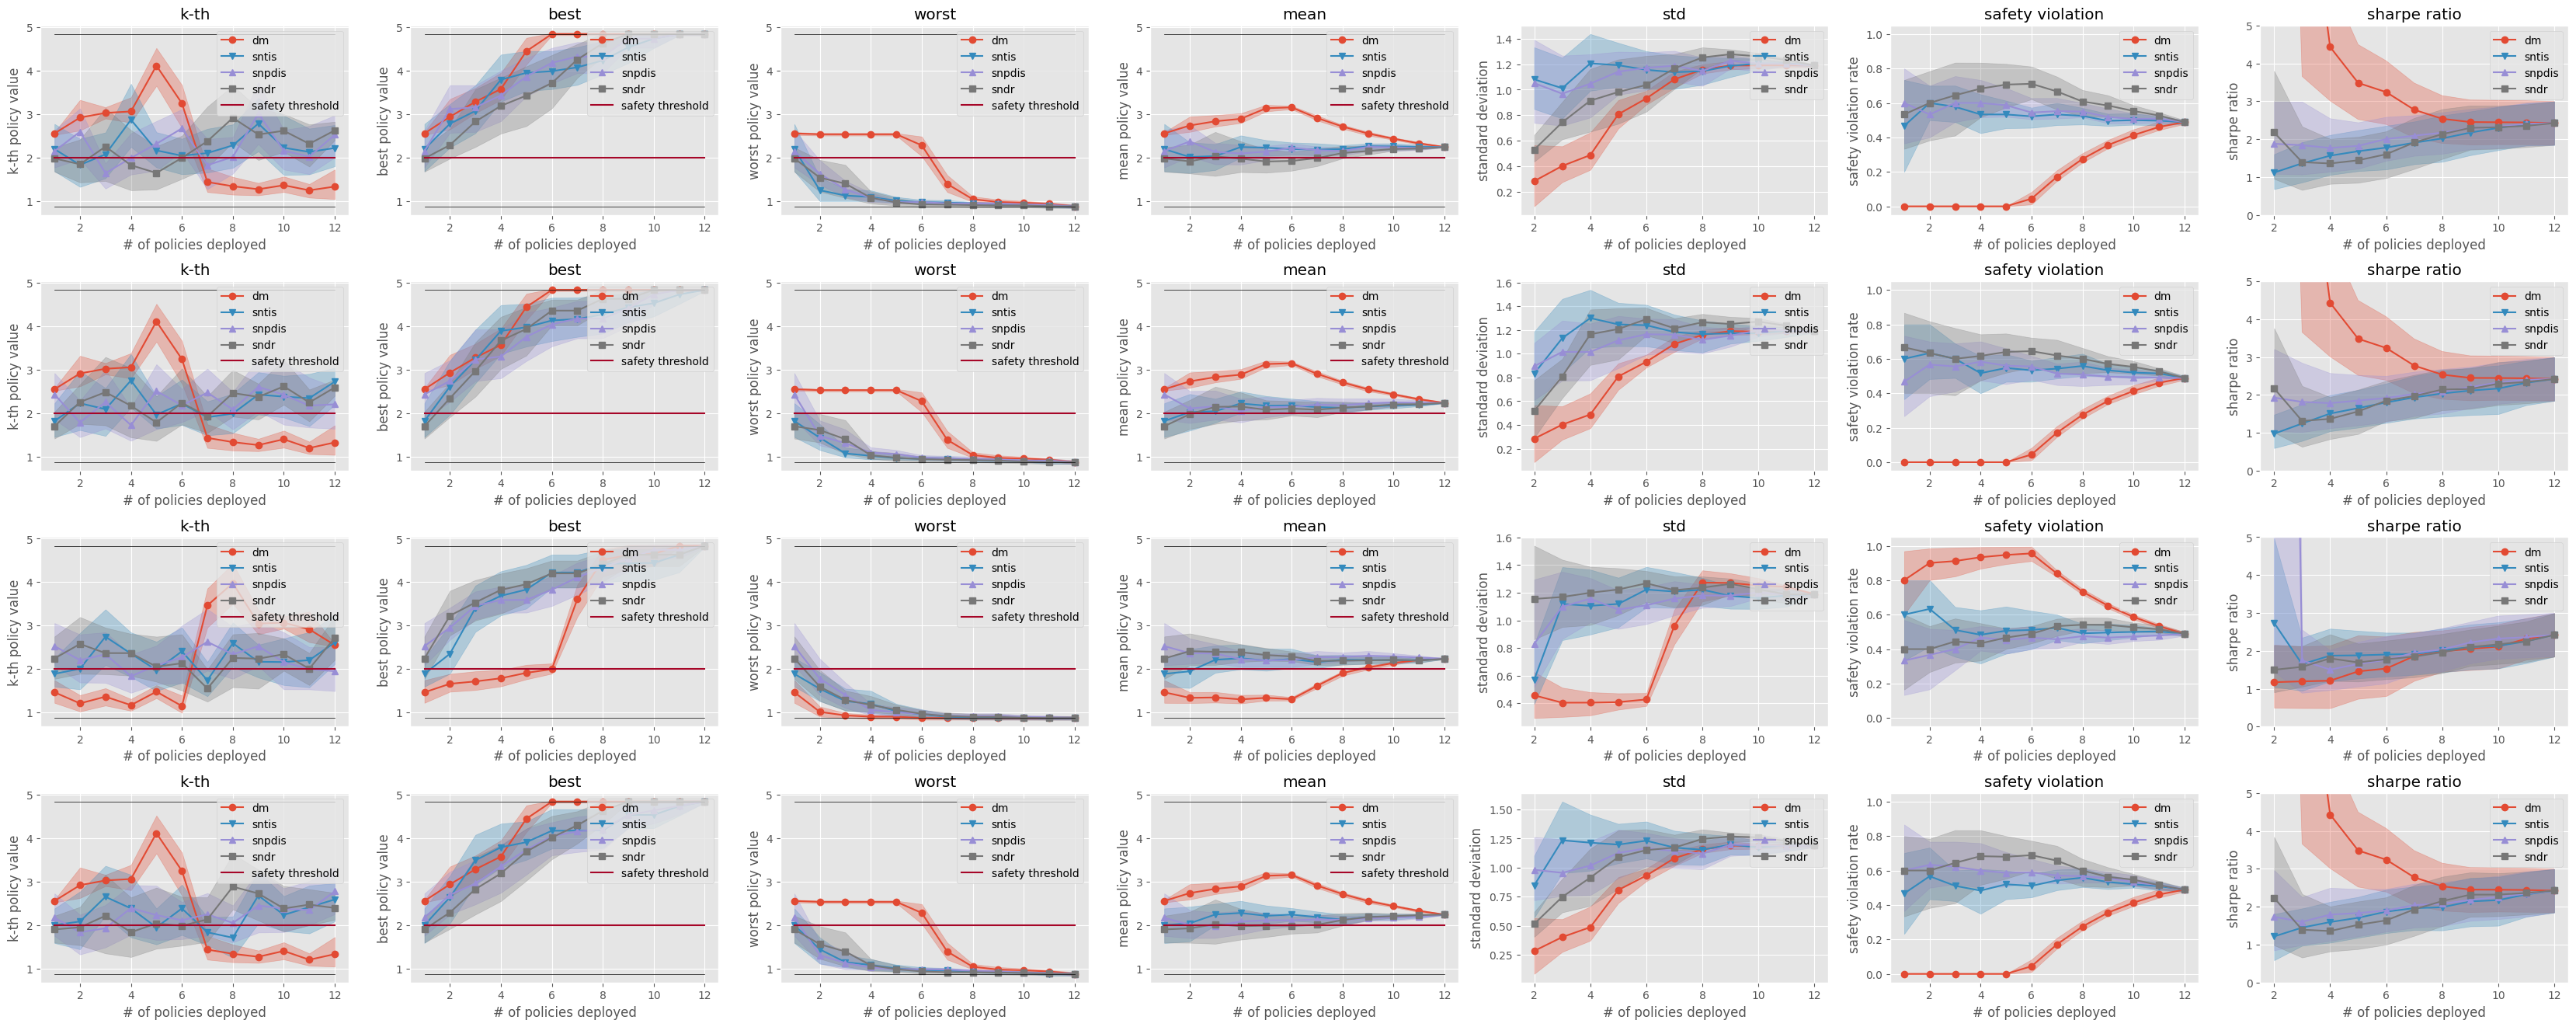

In [37]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_threshold=2.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

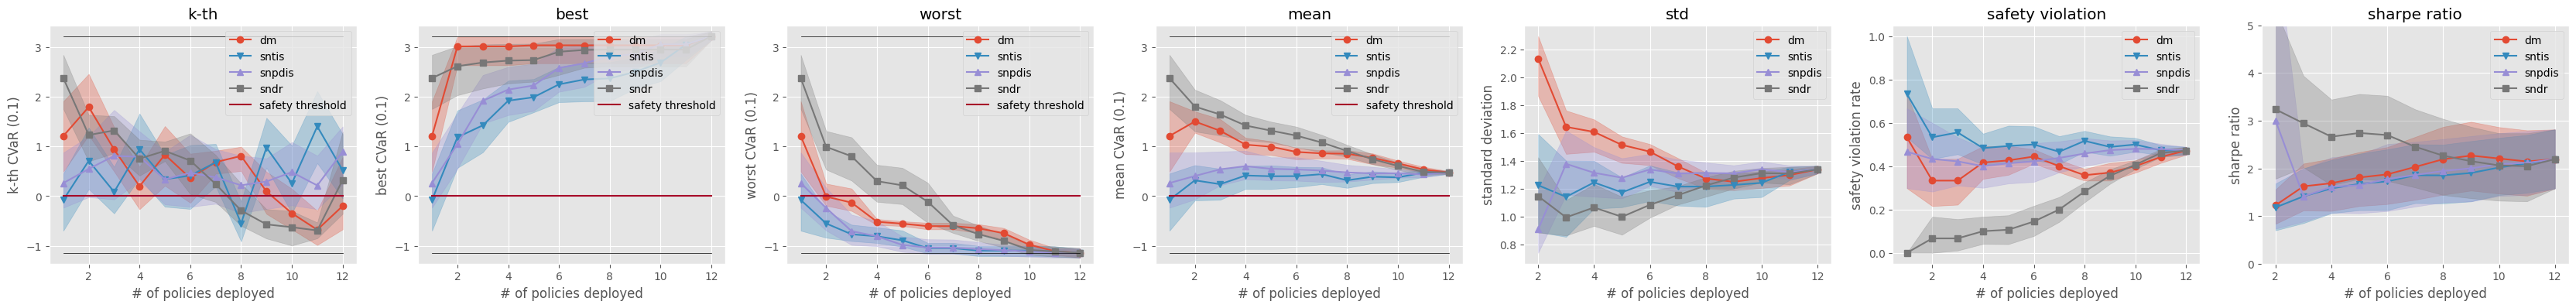

In [38]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

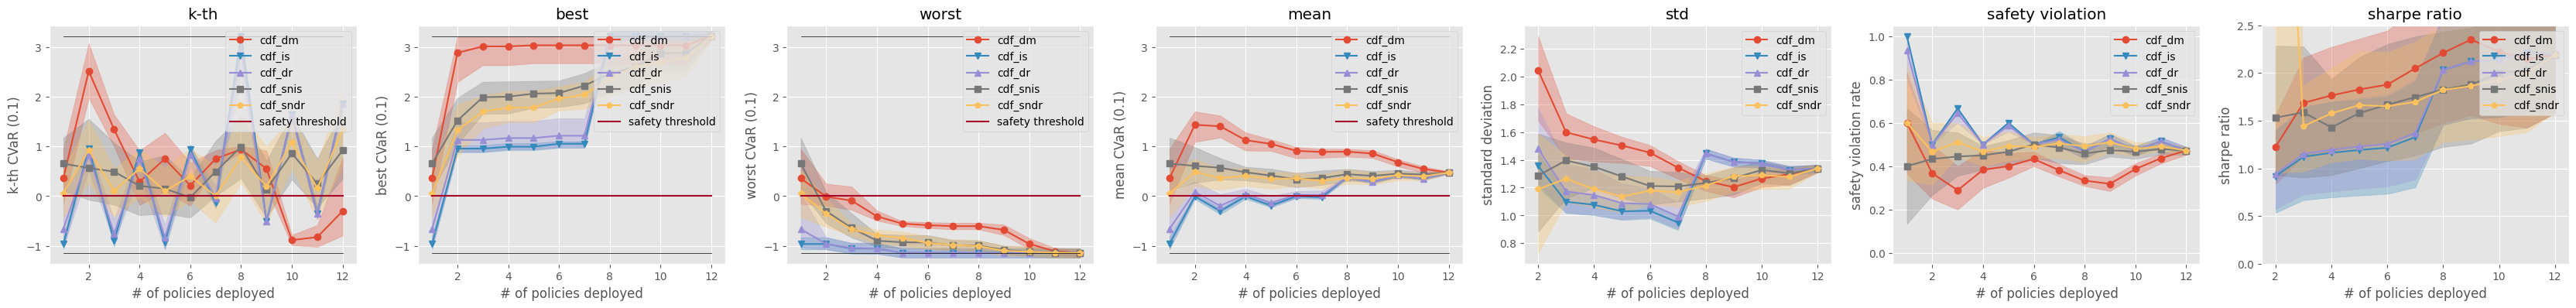

In [39]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

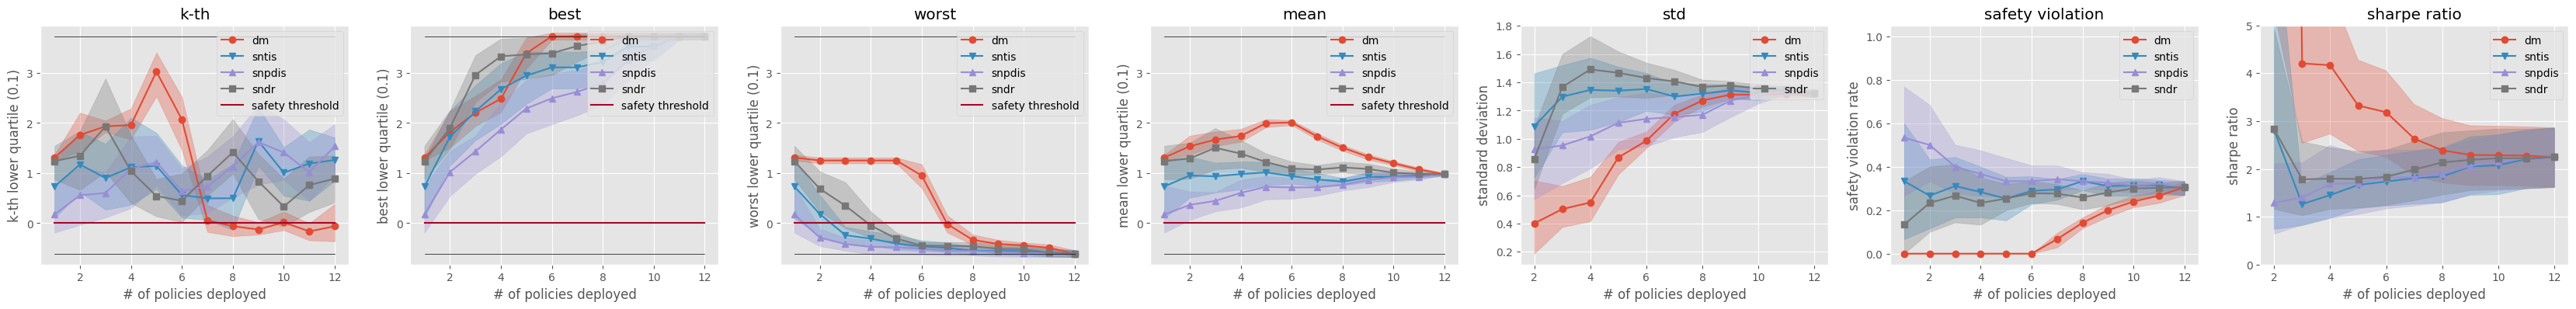

In [40]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

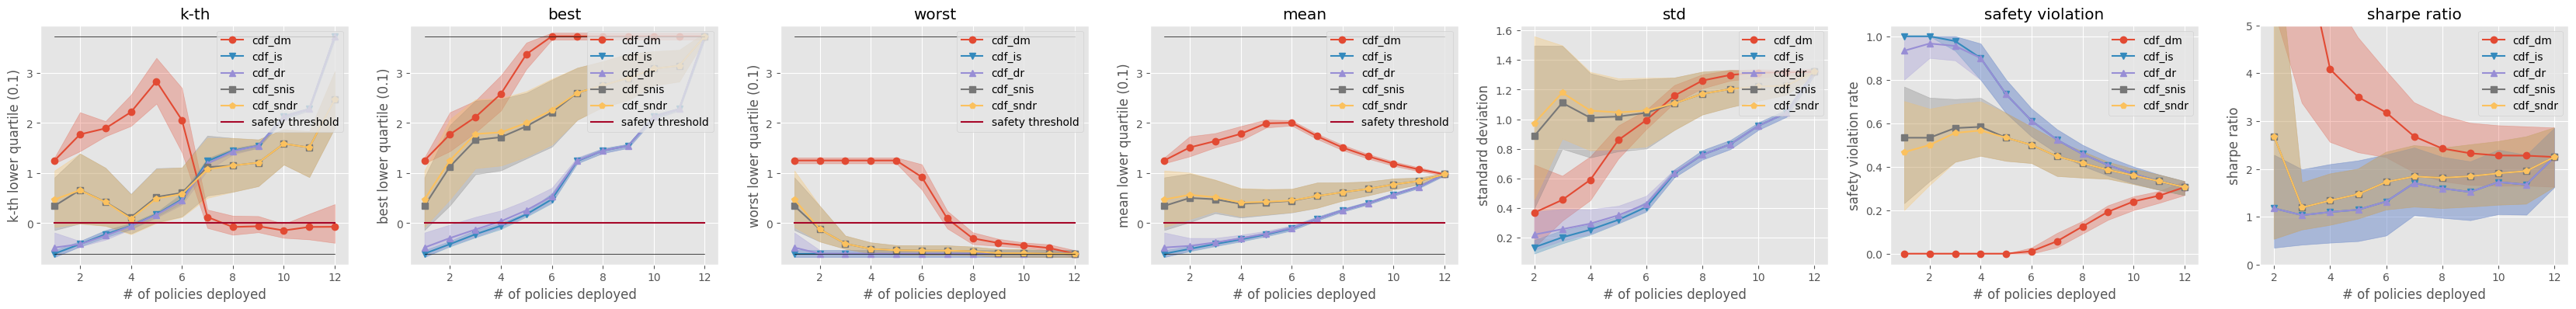

In [41]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=0.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

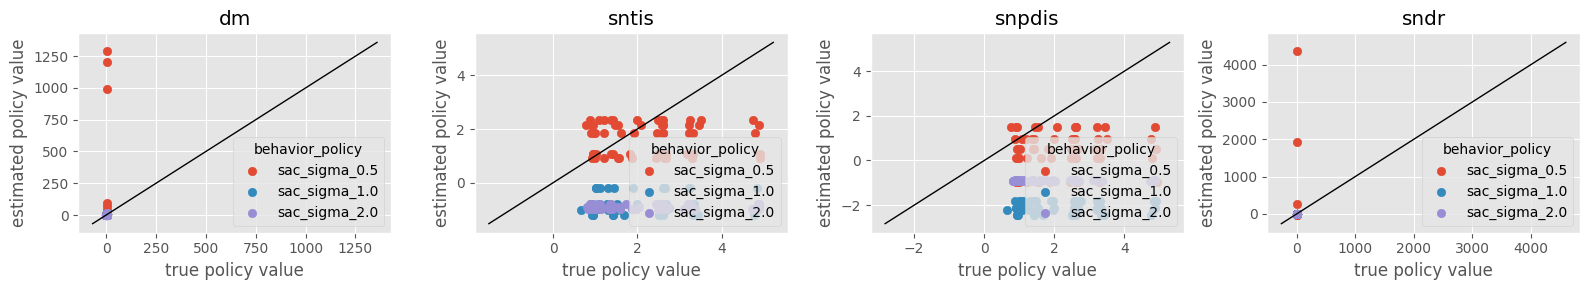

In [42]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=False,
)

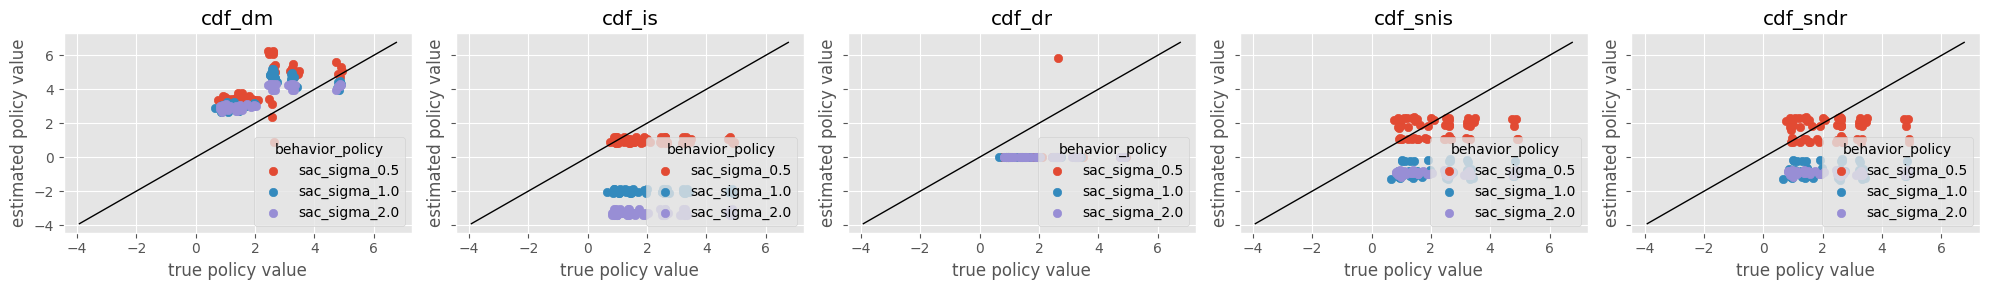

In [43]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

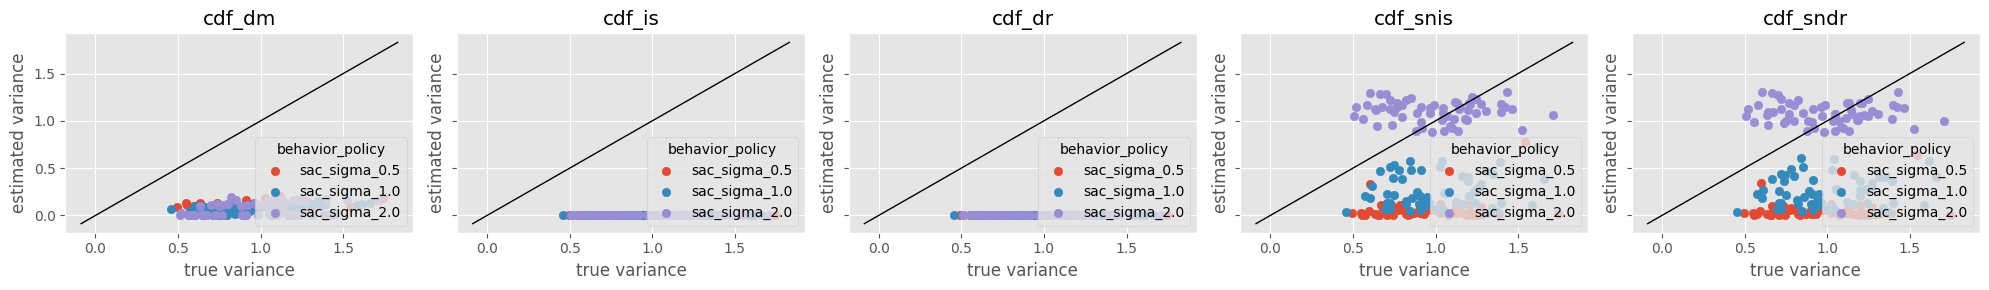

In [44]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

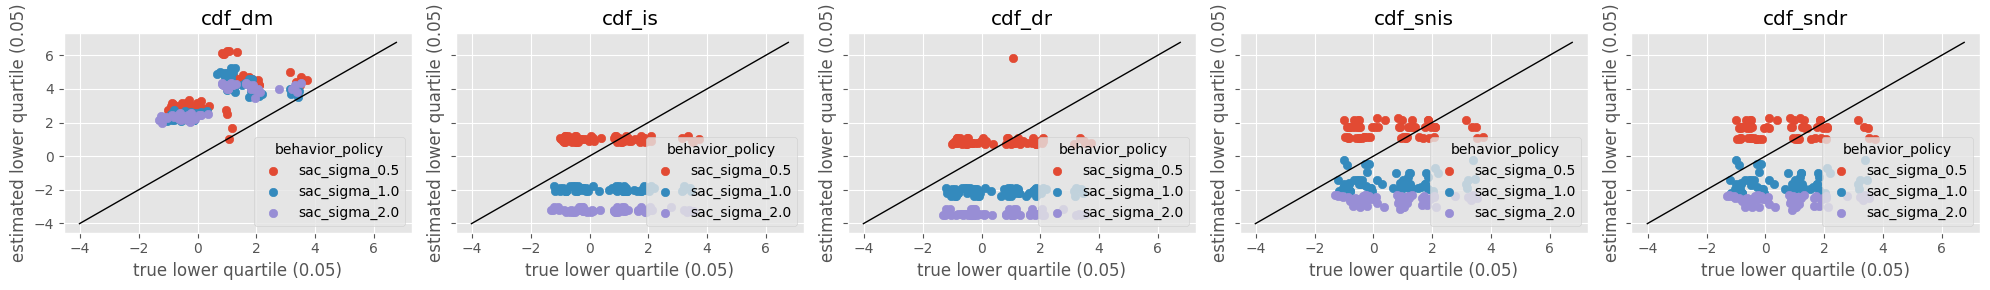

In [45]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

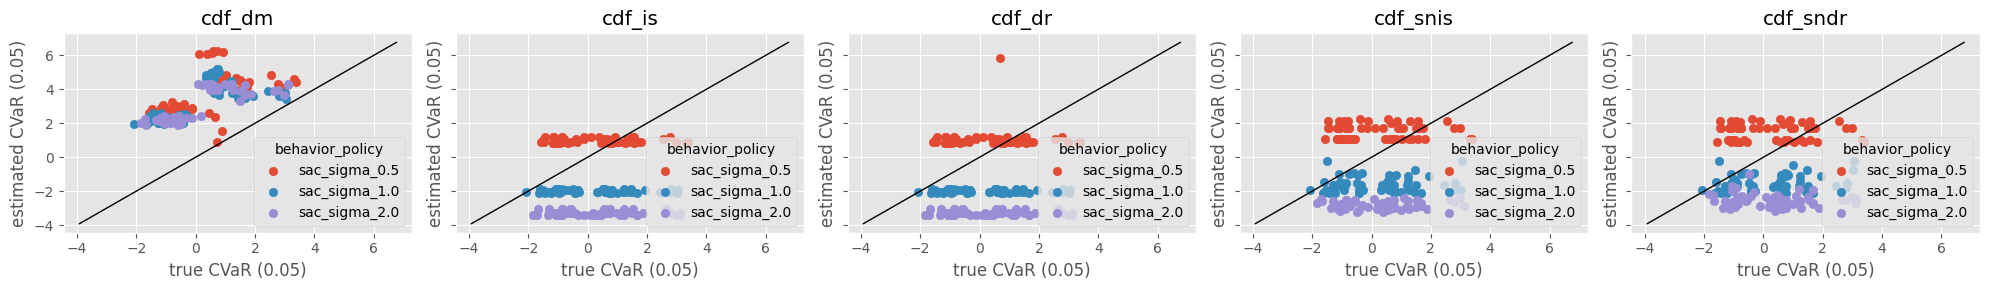

In [46]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the discrete action space, please refer to [examples/quickstart/basic/basic_synthetic_discrete_multiple_datasets.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.